## Import Required Packages and Set File Path

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import brier_score_loss, accuracy_score, log_loss
from sklearn.model_selection import GroupKFold
import xgboost as xgb


# Set the file path
DATA_PATH = "/Users/nicholasrichards/Desktop/march_madness_prediction_project/march-machine-learning-mania-2025/"


## Preparing Dataframes

In [2]:
# Loads tournament seeds data for both men's and women's tournaments
m_tourney_seeds = pd.read_csv(os.path.join(DATA_PATH, "MNCAATourneySeeds.csv")).assign(League="M")
w_tourney_seeds = pd.read_csv(os.path.join(DATA_PATH, "WNCAATourneySeeds.csv")).assign(League="W")
df_seeds = pd.concat([m_tourney_seeds, w_tourney_seeds], ignore_index=True)

# Loads regular season detailed results data for both men's and women's tournaments
m_reg_season = pd.read_csv(os.path.join(DATA_PATH, "MRegularSeasonDetailedResults.csv")).assign(League="M")
w_reg_season = pd.read_csv(os.path.join(DATA_PATH, "WRegularSeasonDetailedResults.csv")).assign(League="W")
df_season_results = pd.concat([m_reg_season, w_reg_season], ignore_index=True)

# Loads NCAA tournament detailed results data for both men's and women's tournaments
m_tourney_results = pd.read_csv(os.path.join(DATA_PATH, "MNCAATourneyDetailedResults.csv")).assign(League="M")
w_tourney_results = pd.read_csv(os.path.join(DATA_PATH, "WNCAATourneyDetailedResults.csv")).assign(League="W")
df_tourney_results = pd.concat([m_tourney_results, w_tourney_results], ignore_index=True)

# Loads team conference data for both men's and women's tournaments
m_team_conferences = pd.read_csv(os.path.join(DATA_PATH, "MTeamConferences.csv")).assign(League="M")
w_team_conferences = pd.read_csv(os.path.join(DATA_PATH, "WTeamConferences.csv")).assign(League="W")
df_team_conferences = pd.concat([m_team_conferences, w_team_conferences], ignore_index=True)

# Loads team data for both men's and women's tournaments 
m_teams = pd.read_csv(os.path.join(DATA_PATH, "MTeams.csv"))
w_teams = pd.read_csv(os.path.join(DATA_PATH, "WTeams.csv"))
df_teams = pd.concat([m_teams, w_teams], ignore_index=True)

# Loads the overall conference data
df_conferences = pd.read_csv(os.path.join(DATA_PATH, "Conferences.csv"))

# Load men's team coaches data
df_team_coaches = pd.read_csv(os.path.join(DATA_PATH, "MTeamCoaches.csv"))

# Load conference tournament games data for both men's and women's tournaments
m_conf_tourney_games = pd.read_csv(os.path.join(DATA_PATH, "MConferenceTourneyGames.csv")).assign(League="M")
w_conf_tourney_games = pd.read_csv(os.path.join(DATA_PATH, "WConferenceTourneyGames.csv")).assign(League="W")
df_conf_tourney_games = pd.concat([m_conf_tourney_games, w_conf_tourney_games], ignore_index=True)

# Load the Sample Submission Stage 2 file
df_sample_submission = pd.read_csv(os.path.join(DATA_PATH, "SampleSubmissionStage2.csv"))

df_season_results.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,League
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,M
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,M
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,M
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,M
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,M


## Creating Team Season Results

In [3]:
# List of detailed stat columns for winners (team stats and opponent stats)
winner_columns = [
    "Season", "League", "WTeamID", "DayNum", "WScore", "LScore",
    "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA",
    "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF",
    "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA",
    "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
    "NumOT"
]

# List of detailed stat columns for losers (order swapped)
loser_columns = [
    "Season", "League", "LTeamID", "DayNum", "WScore", "LScore",
    "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA",
    "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
    "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA",
    "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF",
    "NumOT"
]

# Defining the renaming mapping for winners:
winner_rename = {
    "WTeamID": "TeamID",
    "WScore": "TeamScore",
    "LScore": "OppScore",
    "WFGM": "FGM",
    "WFGA": "FGA",
    "WFGM3": "FGM3",
    "WFGA3": "FGA3",
    "WFTM": "FTM",
    "WFTA": "FTA",
    "WOR": "OR",
    "WDR": "DR",
    "WAst": "Ast",
    "WTO": "TO",
    "WStl": "Stl",
    "WBlk": "Blk",
    "WPF": "PF",
    "LFGM": "OppFGM",
    "LFGA": "OppFGA",
    "LFGM3": "OppFGM3",
    "LFGA3": "OppFGA3",
    "LFTM": "OppFTM",
    "LFTA": "OppFTA",
    "LOR": "OppOR",
    "LDR": "OppDR",
    "LAst": "OppAst",
    "LTO": "OppTO",
    "LStl": "OppStl",
    "LBlk": "OppBlk",
    "LPF": "OppPF"
}

# Defining the renaming mapping for losers:
loser_rename = {
    "LTeamID": "TeamID",
    "LScore": "TeamScore",
    "WScore": "OppScore",
    "LFGM": "FGM",
    "LFGA": "FGA",
    "LFGM3": "FGM3",
    "LFGA3": "FGA3",
    "LFTM": "FTM",
    "LFTA": "FTA",
    "LOR": "OR",
    "LDR": "DR",
    "LAst": "Ast",
    "LTO": "TO",
    "LStl": "Stl",
    "LBlk": "Blk",
    "LPF": "PF",
    "WFGM": "OppFGM",
    "WFGA": "OppFGA",
    "WFGM3": "OppFGM3",
    "WFGA3": "OppFGA3",
    "WFTM": "OppFTM",
    "WFTA": "OppFTA",
    "WOR": "OppOR",
    "WDR": "OppDR",
    "WAst": "OppAst",
    "WTO": "OppTO",
    "WStl": "OppStl",
    "WBlk": "OppBlk",
    "WPF": "OppPF"
}

# Creates the winners DataFrame:
winners_df = (
    df_season_results[winner_columns].copy()
    .assign(GameResult="W")
    .rename(columns=winner_rename)
)

# Creates the losers DataFrame:
losers_df = (
    df_season_results[loser_columns].copy()
    .assign(GameResult="L")
    .rename(columns=loser_rename)
)

# Concatenates the two DataFrames to form the team-level season results
df_team_season_results = pd.concat([winners_df, losers_df], ignore_index=True)

# Calculates the minutes played for each game
df_team_season_results["Min"] = 40 + 5 * df_team_season_results["NumOT"]

# Reorders columns so that the minutes column appears immediately after the NumOT column
cols = list(df_team_season_results.columns)
if "NumOT" in cols and "Min" in cols:
    numot_index = cols.index("NumOT")
    cols.remove("Min")
    cols.insert(numot_index + 1, "Min")
    df_team_season_results = df_team_season_results[cols]

# Sorts by Season, TeamID, and DayNum for clarity
df_team_season_results = df_team_season_results.sort_values(by=["Season", "TeamID", "DayNum"]).reset_index(drop=True)

df_team_season_results.sample(10, random_state=429)

,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,NumOT,Min,GameResult
20110,2005,M,1170,59,71,69,26,59,9,16,...,8,20,11,23,11,4,16,0,40,W
100368,2011,W,3145,36,41,74,15,51,2,14,...,13,34,12,9,4,3,17,0,40,L
82551,2010,W,3244,20,72,61,25,69,3,12,...,20,16,9,19,4,11,23,0,40,W
313830,2021,W,3452,38,45,65,15,54,2,9,...,13,26,15,19,10,6,17,0,40,L
150954,2013,W,3462,87,49,66,19,45,5,21,...,11,21,12,17,6,2,12,0,40,L
61245,2009,M,1227,120,73,68,25,58,7,13,...,9,21,15,7,3,4,19,0,40,W
69027,2010,M,1136,18,51,77,19,56,4,20,...,12,30,19,13,9,7,14,0,40,L
188903,2015,W,3310,45,76,58,26,62,10,27,...,9,26,15,14,3,2,19,0,40,W
143076,2013,W,3189,125,61,71,25,64,4,16,...,17,30,15,8,6,5,12,0,40,L
176919,2015,M,1261,86,64,58,22,48,5,14,...,19,21,11,15,6,7,17,0,40,W


## Creating Season Features

### Features for Points Scored, Points Allowed, and Point Differential

In [4]:
# Creates a binary win indicator: 1 if win ("W"), 0 if loss ("L")
df_team_season_results["Win"] = (df_team_season_results["GameResult"] == "W").astype("int")

# Creates Points Scored, Points Allowed, and Point Differential statistics represented as columns
df_team_season_results["PointsScored"] = df_team_season_results["TeamScore"]
df_team_season_results["PointsAllowed"] = df_team_season_results["OppScore"]
df_team_season_results["PointDiff"] = df_team_season_results["TeamScore"] - df_team_season_results["OppScore"]

df_team_season_results.sample(10, random_state=529)

,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,OppStl,OppBlk,OppPF,NumOT,Min,GameResult,Win,PointsScored,PointsAllowed,PointDiff
361552,2024,M,1256,80,68,54,21,44,6,14,...,11,3,22,0,40,W,1,68,54,14
216242,2017,M,1162,58,67,78,26,55,4,11,...,10,7,18,0,40,L,0,67,78,-11
205113,2016,W,3139,34,50,58,17,56,10,29,...,6,5,13,0,40,L,0,50,58,-8
240815,2018,M,1273,20,70,79,26,56,6,15,...,4,5,20,0,40,L,0,70,79,-9
352374,2023,W,3318,16,59,64,24,54,5,17,...,11,3,14,0,40,L,0,59,64,-5
284229,2020,M,1303,43,56,97,21,63,3,16,...,8,5,17,0,40,L,0,56,97,-41
26737,2005,M,1427,103,88,69,35,66,8,16,...,3,4,21,0,40,W,1,88,69,19
276835,2019,W,3410,54,61,84,20,53,9,25,...,6,5,20,0,40,L,0,61,84,-23
45063,2007,M,1387,91,58,59,19,48,4,15,...,9,7,18,0,40,L,0,58,59,-1
326005,2022,W,3145,73,51,59,19,61,5,24,...,4,4,11,0,40,L,0,51,59,-8


### Features for FG%, 3P%, FT%, eFG%

In [5]:
# Calculates team shooting percentages
df_team_season_results["FG_pct"] = np.where(
    df_team_season_results["FGA"] > 0,
    df_team_season_results["FGM"] / df_team_season_results["FGA"],
    0
)
df_team_season_results["FG3_pct"] = np.where(
    df_team_season_results["FGA3"] > 0,
    df_team_season_results["FGM3"] / df_team_season_results["FGA3"],
    0
)
df_team_season_results["FT_pct"] = np.where(
    df_team_season_results["FTA"] > 0,
    df_team_season_results["FTM"] / df_team_season_results["FTA"],
    0
)

# Calculates opponent shooting percentages
df_team_season_results["Opp_FG_pct"] = np.where(
    df_team_season_results["OppFGA"] > 0,
    df_team_season_results["OppFGM"] / df_team_season_results["OppFGA"],
    0
)
df_team_season_results["Opp_FG3_pct"] = np.where(
    df_team_season_results["OppFGA3"] > 0,
    df_team_season_results["OppFGM3"] / df_team_season_results["OppFGA3"],
    0
)
df_team_season_results["Opp_FT_pct"] = np.where(
    df_team_season_results["OppFTA"] > 0,
    df_team_season_results["OppFTM"] / df_team_season_results["OppFTA"],
    0
)

# Calculates effective field goal percentage for team
df_team_season_results["eFG_pct"] = np.where(
    df_team_season_results["FGA"] > 0,
    (df_team_season_results["FGM"] + 0.5 * df_team_season_results["FGM3"]) / df_team_season_results["FGA"],
    0
)

# Calculates effective field goal percentage for opponent
df_team_season_results["Opp_eFG_pct"] = np.where(
    df_team_season_results["OppFGA"] > 0,
    (df_team_season_results["OppFGM"] + 0.5 * df_team_season_results["OppFGM3"]) / df_team_season_results["OppFGA"],
    0
)

df_team_season_results.sample(10, random_state=349)

,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,PointsAllowed,PointDiff,FG_pct,FG3_pct,FT_pct,Opp_FG_pct,Opp_FG3_pct,Opp_FT_pct,eFG_pct,Opp_eFG_pct
134389,2013,M,1254,59,73,77,23,51,7,24,...,77,-4,0.450980,0.291667,0.769231,0.537037,0.529412,0.769231,0.519608,0.620370
18089,2004,M,1454,110,76,83,25,59,5,17,...,83,-7,0.423729,0.294118,0.840000,0.566038,0.529412,0.777778,0.466102,0.650943
158125,2014,M,1343,127,70,65,22,51,8,24,...,65,5,0.431373,0.333333,0.666667,0.440678,0.277778,0.571429,0.509804,0.483051
135932,2013,M,1307,18,73,58,24,47,10,20,...,58,15,0.510638,0.500000,0.681818,0.410714,0.333333,0.500000,0.617021,0.482143
224591,2017,M,1438,124,67,42,27,62,11,22,...,42,25,0.435484,0.500000,1.000000,0.333333,0.200000,1.000000,0.524194,0.377778
52326,2008,M,1279,26,85,77,28,55,9,23,...,77,8,0.509091,0.391304,0.606061,0.465517,0.428571,0.700000,0.590909,0.543103
261215,2019,M,1245,103,71,58,22,51,6,18,...,58,13,0.431373,0.333333,0.724138,0.416667,0.250000,0.619048,0.490196,0.468750
338382,2023,M,1217,58,74,73,30,61,5,21,...,73,1,0.491803,0.238095,0.600000,0.417910,0.379310,0.750000,0.532787,0.500000
100792,2011,W,3161,17,52,63,17,54,4,19,...,63,-11,0.314815,0.210526,0.700000,0.354839,0.277778,0.583333,0.351852,0.395161
259179,2019,M,1178,110,75,95,25,68,8,23,...,95,-20,0.367647,0.347826,0.809524,0.581818,0.500000,0.826087,0.426471,0.690909


### Rebounding Features 

In [6]:
# Calculates total rebounds for the team and the opponent
df_team_season_results["Team_Rebounds"] = df_team_season_results["OR"] + df_team_season_results["DR"]
df_team_season_results["Opp_Rebounds"] = df_team_season_results["OppOR"] + df_team_season_results["OppDR"]

# Calculates rebound margin
df_team_season_results["ReboundMargin"] = df_team_season_results["Team_Rebounds"] - df_team_season_results["Opp_Rebounds"]

df_team_season_results.sample(10, random_state=529)

,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,FG3_pct,FT_pct,Opp_FG_pct,Opp_FG3_pct,Opp_FT_pct,eFG_pct,Opp_eFG_pct,Team_Rebounds,Opp_Rebounds,ReboundMargin
361552,2024,M,1256,80,68,54,21,44,6,14,...,0.428571,0.606061,0.295082,0.176471,0.681818,0.545455,0.319672,41,25,16
216242,2017,M,1162,58,67,78,26,55,4,11,...,0.363636,0.687500,0.547170,0.400000,0.571429,0.509091,0.622642,24,34,-10
205113,2016,W,3139,34,50,58,17,56,10,29,...,0.344828,0.666667,0.294118,0.208333,0.812500,0.392857,0.330882,39,51,-12
240815,2018,M,1273,20,70,79,26,56,6,15,...,0.400000,0.800000,0.480000,0.380952,0.766667,0.517857,0.560000,29,32,-3
352374,2023,W,3318,16,59,64,24,54,5,17,...,0.294118,0.600000,0.389831,0.238095,0.722222,0.490741,0.432203,21,38,-17
284229,2020,M,1303,43,56,97,21,63,3,16,...,0.187500,0.687500,0.541667,0.361111,0.600000,0.357143,0.631944,32,49,-17
26737,2005,M,1427,103,88,69,35,66,8,16,...,0.500000,0.476190,0.407407,0.333333,0.782609,0.590909,0.472222,44,28,16
276835,2019,W,3410,54,61,84,20,53,9,25,...,0.360000,0.800000,0.527273,0.500000,0.724138,0.462264,0.572727,17,48,-31
45063,2007,M,1387,91,58,59,19,48,4,15,...,0.266667,0.727273,0.343284,0.258065,0.500000,0.437500,0.402985,45,35,10
326005,2022,W,3145,73,51,59,19,61,5,24,...,0.208333,0.666667,0.368421,0.315789,0.550000,0.352459,0.421053,38,39,-1


### Possession and Pace Features

In [7]:
# Calculates team possessions 
df_team_season_results["Team_Possessions"] = (
    df_team_season_results["FGA"] +
    0.44 * df_team_season_results["FTA"] -
    df_team_season_results["OR"] +
    df_team_season_results["TO"]
)

# Calculates opponent possessions
df_team_season_results["Opp_Possessions"] = (
    df_team_season_results["OppFGA"] +
    0.44 * df_team_season_results["OppFTA"] -
    df_team_season_results["OppOR"] +
    df_team_season_results["OppTO"]
)

# Calculates possession margin
df_team_season_results["PossessionMargin"] = (
    df_team_season_results["Team_Possessions"] - df_team_season_results["Opp_Possessions"]
)

# Calculates the team's tempo
df_team_season_results["Team_Tempo"] = df_team_season_results["Team_Possessions"] / (df_team_season_results["Min"] / 40)

# Calculates the opponent's tempo
df_team_season_results["Opp_Tempo"] = df_team_season_results["Opp_Possessions"] / (df_team_season_results["Min"] / 40)

df_team_season_results.sample(10, random_state=529)


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,eFG_pct,Opp_eFG_pct,Team_Rebounds,Opp_Rebounds,ReboundMargin,Team_Possessions,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo
361552,2024,M,1256,80,68,54,21,44,6,14,...,0.545455,0.319672,41,25,16,68.52,73.68,-5.16,68.52,73.68
216242,2017,M,1162,58,67,78,26,55,4,11,...,0.509091,0.622642,24,34,-10,74.04,72.24,1.80,74.04,72.24
205113,2016,W,3139,34,50,58,17,56,10,29,...,0.392857,0.330882,39,51,-12,66.96,69.04,-2.08,66.96,69.04
240815,2018,M,1273,20,70,79,26,56,6,15,...,0.517857,0.560000,29,32,-3,66.60,67.20,-0.60,66.60,67.20
352374,2023,W,3318,16,59,64,24,54,5,17,...,0.490741,0.432203,21,38,-17,76.40,71.92,4.48,76.40,71.92
284229,2020,M,1303,43,56,97,21,63,3,16,...,0.357143,0.631944,32,49,-17,79.04,80.40,-1.36,79.04,80.40
26737,2005,M,1427,103,88,69,35,66,8,16,...,0.590909,0.472222,44,28,16,65.24,64.12,1.12,65.24,64.12
276835,2019,W,3410,54,61,84,20,53,9,25,...,0.462264,0.572727,17,48,-31,70.60,71.76,-1.16,70.60,71.76
45063,2007,M,1387,91,58,59,19,48,4,15,...,0.437500,0.402985,45,35,10,63.68,64.40,-0.72,63.68,64.40
326005,2022,W,3145,73,51,59,19,61,5,24,...,0.352459,0.421053,38,39,-1,67.28,66.80,0.48,67.28,66.80


### Assist and Turnover Features

In [8]:
# Calculatea team's assist-to-turnover ratio
df_team_season_results["AST_TO"] = np.where(
    df_team_season_results["TO"] > 0,
    df_team_season_results["Ast"] / df_team_season_results["TO"],
    0
)

# Calculates opponent's assist-to-turnover ratio
df_team_season_results["Opp_AST_TO"] = np.where(
    df_team_season_results["OppTO"] > 0,
    df_team_season_results["OppAst"] / df_team_season_results["OppTO"],
    0
)

df_team_season_results.head()


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,Team_Rebounds,Opp_Rebounds,ReboundMargin,Team_Possessions,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo,AST_TO,Opp_AST_TO
0,2003,M,1102,19,47,65,16,40,6,21,...,20,39,-19,61.04,60.80,0.24,61.04,60.80,0.470588,0.857143
1,2003,M,1102,22,72,43,26,46,15,28,...,27,27,0,53.08,53.60,-0.52,53.08,53.60,2.111111,0.454545
2,2003,M,1102,25,57,52,16,36,7,20,...,27,24,3,52.68,53.24,-0.56,52.68,53.24,1.000000,1.000000
3,2003,M,1102,27,47,60,15,35,10,19,...,9,31,-22,51.28,49.80,1.48,51.28,49.80,1.083333,0.928571
4,2003,M,1102,31,65,44,23,40,18,33,...,19,28,-9,45.08,45.96,-0.88,45.08,45.96,2.857143,0.538462


### Offensive and Defensive Efficiency Features

In [9]:
# Calculates team's offensive efficiency
df_team_season_results["Team_OffEff"] = (df_team_season_results["TeamScore"] / df_team_season_results["Team_Possessions"]) * 100

# Calculates team's defensive efficiency
df_team_season_results["Team_DefEff"] = (df_team_season_results["OppScore"] / df_team_season_results["Opp_Possessions"]) * 100

# Calculates opponent's offensive efficiency
df_team_season_results["Opp_OffEff"] = (df_team_season_results["OppScore"] / df_team_season_results["Opp_Possessions"]) * 100

# Calculates opponent's defensive efficiency
df_team_season_results["Opp_DefEff"] = (df_team_season_results["TeamScore"] / df_team_season_results["Team_Possessions"]) * 100

df_team_season_results.sample(10, random_state=529)


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo,AST_TO,Opp_AST_TO,Team_OffEff,Team_DefEff,Opp_OffEff,Opp_DefEff
361552,2024,M,1256,80,68,54,21,44,6,14,...,73.68,-5.16,68.52,73.68,0.555556,0.666667,99.241097,73.289902,73.289902,99.241097
216242,2017,M,1162,58,67,78,26,55,4,11,...,72.24,1.80,74.04,72.24,1.125000,0.750000,90.491626,107.973422,107.973422,90.491626
205113,2016,W,3139,34,50,58,17,56,10,29,...,69.04,-2.08,66.96,69.04,0.866667,0.923077,74.671446,84.009270,84.009270,74.671446
240815,2018,M,1273,20,70,79,26,56,6,15,...,67.20,-0.60,66.60,67.20,0.571429,1.000000,105.105105,117.559524,117.559524,105.105105
352374,2023,W,3318,16,59,64,24,54,5,17,...,71.92,4.48,76.40,71.92,0.478261,0.590909,77.225131,88.987764,88.987764,77.225131
284229,2020,M,1303,43,56,97,21,63,3,16,...,80.40,-1.36,79.04,80.40,0.764706,1.866667,70.850202,120.646766,120.646766,70.850202
26737,2005,M,1427,103,88,69,35,66,8,16,...,64.12,1.12,65.24,64.12,2.444444,0.727273,134.886573,107.610730,107.610730,134.886573
276835,2019,W,3410,54,61,84,20,53,9,25,...,71.76,-1.16,70.60,71.76,0.733333,1.000000,86.402266,117.056856,117.056856,86.402266
45063,2007,M,1387,91,58,59,19,48,4,15,...,64.40,-0.72,63.68,64.40,0.473684,1.444444,91.080402,91.614907,91.614907,91.080402
326005,2022,W,3145,73,51,59,19,61,5,24,...,66.80,0.48,67.28,66.80,0.538462,1.300000,75.802616,88.323353,88.323353,75.802616


## Aggregate for team's total season stats

In [10]:
# Aggregate the season results per team with additional features
team_season_agg = (
    df_team_season_results.groupby(["Season", "TeamID", "League"])
    .agg(
        # Score differentials and win metrics
        AvgPointDiff=("PointDiff", "mean"),         # Average score differential per team
        MedianPointDiff=("PointDiff", "median"),      # Median score differential per team
        MinPointDiff=("PointDiff", "min"),            # Minimum score differential per team
        MaxPointDiff=("PointDiff", "max"),            # Maximum score differential per team
        Wins=("Win", "sum"),                          # Total wins (since Win is binary)
        Losses=("GameResult", lambda x: (x == "L").sum()),  # Count of losses
        WinPercentage=("Win", "mean"),                # Win percentage (mean of binary wins)
        
        # Scoring aggregates
        AvgPointsScored=("PointsScored", "mean"),     # Average points scored per game
        AvgPointsAllowed=("PointsAllowed", "mean"),   # Average points allowed per game
        AvgPointDifferential=("PointDiff", "mean"),   # Average point differential per game
        
        # Shooting efficiency averages
        Avg_FG_pct=("FG_pct", "mean"),                # Average field goal percentage
        Avg_FG3_pct=("FG3_pct", "mean"),              # Average three-point percentage
        Avg_FT_pct=("FT_pct", "mean"),                # Average free throw percentage
        Avg_eFG_pct=("eFG_pct", "mean"),              # Average effective field goal percentage
        
        # Rebounding and possessions
        AvgReboundMargin=("ReboundMargin", "mean"),     # Average rebound margin
        AvgTeamPossessions=("Team_Possessions", "mean"),  # Average team possessions per game
        AvgPossessionMargin=("PossessionMargin", "mean"), # Average possession margin
        
        # Tempo calculations
        AvgTeamTempo=("Team_Tempo", "mean"),            # Average team tempo (possessions per 40 minutes)
        
        # Efficiency metrics
        Avg_OffEff=("Team_OffEff", "mean"),             # Average offensive efficiency (points per 100 possessions)
        Avg_DefEff=("Team_DefEff", "mean"),             # Average defensive efficiency (opponent points per 100 possessions)
        
        # Assists and turnovers
        Avg_AST_TO=("AST_TO", "mean"),                # Average assist-to-turnover ratio
        Avg_Assists=("Ast", "mean"),                  # Average assists per game
        Avg_Turnovers=("TO", "mean"),                 # Average turnovers per game
        
        # Average steals and blocks per game
        Avg_Steals=("Stl", "mean"),                   # Average steals per game
        Avg_Blocks=("Blk", "mean")                    # Average blocks per game
    )
    .reset_index()
)

team_season_agg.head()

,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,AvgTeamPossessions,AvgPossessionMargin,AvgTeamTempo,Avg_OffEff,Avg_DefEff,Avg_AST_TO,Avg_Assists,Avg_Turnovers,Avg_Steals,Avg_Blocks
0,2003,1102,M,0.250000,-3.0,-32,38,12,16,0.428571,...,54.562857,0.307143,54.562857,104.902619,105.142005,1.375064,13.000000,11.428571,5.964286,1.785714
1,2003,1103,M,0.629630,-2.0,-16,33,13,14,0.481481,...,70.078519,0.037037,67.656461,111.985073,111.829472,1.324485,15.222222,12.629630,7.259259,2.333333
2,2003,1104,M,4.285714,6.0,-19,28,17,11,0.607143,...,66.101429,0.094286,65.848254,104.527648,98.975644,0.992390,12.107143,13.285714,6.607143,3.785714
3,2003,1105,M,-4.884615,-3.5,-42,34,7,19,0.269231,...,76.381538,1.024615,74.933607,93.942187,102.129410,0.861957,14.538462,18.653846,9.307692,2.076923
4,2003,1106,M,-0.142857,-1.0,-26,26,13,15,0.464286,...,67.280000,0.472857,66.979206,94.469094,95.562829,0.723189,11.678571,17.035714,8.357143,3.142857


### Calculating Adjusted Efficiency Features

In [11]:
# Calculates league averages for offensive and defensive efficiency per Season and League
league_avgs = team_season_agg.groupby(["Season", "League"]).agg(
    LeagueAvgOffEff=("Avg_OffEff", "mean"),
    LeagueAvgDefEff=("Avg_DefEff", "mean")
).reset_index()

# Merges league averages back into team_season_agg
team_season_agg = team_season_agg.merge(league_avgs, on=["Season", "League"], how="left")

# Calculates adjusted efficiencies
# Normalizing by the league average so that a league-average performance equals 100
# Adjusted Offensive Efficiency:
team_season_agg["AdjOffEff"] = (team_season_agg["Avg_OffEff"] / team_season_agg["LeagueAvgOffEff"]) * 100
# Adjusted Defensive Efficiency:
team_season_agg["AdjDefEff"] = (team_season_agg["Avg_DefEff"] / team_season_agg["LeagueAvgDefEff"]) * 100

team_season_agg.head()

,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,Avg_DefEff,Avg_AST_TO,Avg_Assists,Avg_Turnovers,Avg_Steals,Avg_Blocks,LeagueAvgOffEff,LeagueAvgDefEff,AdjOffEff,AdjDefEff
0,2003,1102,M,0.250000,-3.0,-32,38,12,16,0.428571,...,105.142005,1.375064,13.000000,11.428571,5.964286,1.785714,101.970943,102.24465,102.875011,102.833747
1,2003,1103,M,0.629630,-2.0,-16,33,13,14,0.481481,...,111.829472,1.324485,15.222222,12.629630,7.259259,2.333333,101.970943,102.24465,109.820572,109.374399
2,2003,1104,M,4.285714,6.0,-19,28,17,11,0.607143,...,98.975644,0.992390,12.107143,13.285714,6.607143,3.785714,101.970943,102.24465,102.507287,96.802761
3,2003,1105,M,-4.884615,-3.5,-42,34,7,19,0.269231,...,102.129410,0.861957,14.538462,18.653846,9.307692,2.076923,101.970943,102.24465,92.126428,99.887289
4,2003,1106,M,-0.142857,-1.0,-26,26,13,15,0.464286,...,95.562829,0.723189,11.678571,17.035714,8.357143,3.142857,101.970943,102.24465,92.643150,93.464870


In [12]:
# Processes chalk seeds by removing play-in suffixes and extracting the numeric seed
df_seeds["ChalkSeed"] = (
    df_seeds["Seed"].str.replace("a", "", regex=False)
    .str.replace("b", "", regex=False)
    .str[1:]
    .astype("int")
)

# Merges seed information with team season aggregates
team_season_agg = team_season_agg.merge(
    df_seeds[["Season", "TeamID", "League", "ChalkSeed"]],
    on=["Season", "TeamID", "League"],
    how="left"
)

# For teams without a tournament seed fill missing values with a default value of 17
team_season_agg["ChalkSeed"] = team_season_agg["ChalkSeed"].fillna(17)

print(team_season_agg.shape, df_seeds.shape)


(13583, 33) (4370, 5)


## Creating Tournament Results Aggregation

In [13]:
df_team_tourney_results = pd.concat(
    [
        # For winners uses detailed stats from the winner side and opponent stats from the loser side
        df_tourney_results[
            [
                "Season", "League",
                "WTeamID", "LTeamID",
                "WScore", "LScore",
                "WFGM", "WFGA", "WFGM3", "WFGA3",
                "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF",
                "LFGM", "LFGA", "LFGM3", "LFGA3",
                "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF"
            ]
        ]
        .assign(GameResult="W")
        .rename(
            columns={
                "WTeamID": "TeamID",
                "LTeamID": "OppTeamID",
                "WScore": "TeamScore",
                "LScore": "OppScore",
                "WFGM": "FGM",
                "WFGA": "FGA",
                "WFGM3": "FGM3",
                "WFGA3": "FGA3",
                "WFTM": "FTM",
                "WFTA": "FTA",
                "WOR": "OR",
                "WDR": "DR",
                "WAst": "Ast",
                "WTO": "TO",
                "WStl": "Stl",
                "WBlk": "Blk",
                "WPF": "PF",
                "LFGM": "OppFGM",
                "LFGA": "OppFGA",
                "LFGM3": "OppFGM3",
                "LFGA3": "OppFGA3",
                "LFTM": "OppFTM",
                "LFTA": "OppFTA",
                "LOR": "OppOR",
                "LDR": "OppDR",
                "LAst": "OppAst",
                "LTO": "OppTO",
                "LStl": "OppStl",
                "LBlk": "OppBlk",
                "LPF": "OppPF",
            }
        ),
        # For losers uses detailed stats from the loser side and opponent stats from the winner side
        df_tourney_results[
            [
                "Season", "League",
                "LTeamID", "WTeamID",
                "LScore", "WScore",
                "LFGM", "LFGA", "LFGM3", "LFGA3",
                "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
                "WFGM", "WFGA", "WFGM3", "WFGA3",
                "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"
            ]
        ]
        .assign(GameResult="L")
        .rename(
            columns={
                "LTeamID": "TeamID",
                "WTeamID": "OppTeamID",
                "LScore": "TeamScore",
                "WScore": "OppScore",
                "LFGM": "FGM",
                "LFGA": "FGA",
                "LFGM3": "FGM3",
                "LFGA3": "FGA3",
                "LFTM": "FTM",
                "LFTA": "FTA",
                "LOR": "OR",
                "LDR": "DR",
                "LAst": "Ast",
                "LTO": "TO",
                "LStl": "Stl",
                "LBlk": "Blk",
                "LPF": "PF",
                "WFGM": "OppFGM",
                "WFGA": "OppFGA",
                "WFGM3": "OppFGM3",
                "WFGA3": "OppFGA3",
                "WFTM": "OppFTM",
                "WFTA": "OppFTA",
                "WOR": "OppOR",
                "WDR": "OppDR",
                "WAst": "OppAst",
                "WTO": "OppTO",
                "WStl": "OppStl",
                "WBlk": "OppBlk",
                "WPF": "OppPF",
            }
        )
    ]
).reset_index(drop=True)

# Creates a binary win indicator column: 1 for wins, 0 for losses
df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype("int")

df_team_tourney_results

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,GameResult,Win
0,2003,M,1421,1411,92,84,32,69,11,29,...,31,17,28,16,15,5,0,22,W,1
1,2003,M,1112,1436,80,51,31,66,7,23,...,7,8,26,12,17,10,3,15,W,1
2,2003,M,1113,1272,84,71,31,59,6,14,...,21,20,22,11,12,2,5,18,W,1
3,2003,M,1141,1166,79,73,29,53,3,7,...,17,14,17,20,21,6,6,21,W,1
4,2003,M,1143,1301,76,74,27,64,7,20,...,20,10,26,16,14,5,8,19,W,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,2024,W,3425,3163,73,80,23,70,9,29,...,27,5,30,17,12,6,5,21,L,0
4548,2024,W,3261,3234,87,94,34,88,8,24,...,22,3,29,16,11,6,3,15,L,0
4549,2024,W,3163,3234,69,71,29,63,8,25,...,14,9,23,12,16,7,1,9,L,0
4550,2024,W,3301,3376,59,78,20,62,6,23,...,4,10,34,18,15,10,6,16,L,0


## Tourney Dataset with Features

In [14]:
# Merges team regular season aggregates into tournament features
df_historic_tourney_features = (
    df_team_tourney_results.merge(
        team_season_agg, on=["Season", "League", "TeamID"], how="left"
    )
    # Merges opponent regular season aggregates after renaming TeamID to OppTeamID
    # Use suffixes to distinguish overlapping column names
    .merge(
        team_season_agg.rename(columns={"TeamID": "OppTeamID"}),
        on=["Season", "League", "OppTeamID"],
        how="left",
        suffixes=("", "_opp")
    )
)

# Merges team names for the team side using df_teams
df_historic_tourney_features = df_historic_tourney_features.merge(
    df_teams[["TeamID", "TeamName"]],
    on="TeamID",
    how="left"
)

# Merges team names for the opponent side
# Rename the columns in df_teams so that TeamID becomes OppTeamID and TeamName becomes OppTeamName
df_historic_tourney_features = df_historic_tourney_features.merge(
    df_teams[["TeamID", "TeamName"]].rename(
        columns={"TeamID": "OppTeamID", "TeamName": "OppTeamName"}
    ),
    on="OppTeamID",
    how="left"
)

df_historic_tourney_features.head()

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,Avg_Turnovers_opp,Avg_Steals_opp,Avg_Blocks_opp,LeagueAvgOffEff_opp,LeagueAvgDefEff_opp,AdjOffEff_opp,AdjDefEff_opp,ChalkSeed_opp,TeamName,OppTeamName
0,2003,M,1421,1411,92,84,32,69,11,29,...,15.233333,6.433333,2.233333,101.970943,102.24465,102.358333,97.830225,16.0,UNC Asheville,TX Southern
1,2003,M,1112,1436,80,51,31,66,7,23,...,14.068966,6.862069,2.965517,101.970943,102.24465,101.709715,94.494231,16.0,Arizona,Vermont
2,2003,M,1113,1272,84,71,31,59,6,14,...,13.793103,7.379310,5.068966,101.970943,102.24465,104.644228,92.342235,7.0,Arizona St,Memphis
3,2003,M,1141,1166,79,73,29,53,3,7,...,13.363636,8.393939,4.454545,101.970943,102.24465,112.757016,91.831605,6.0,C Michigan,Creighton
4,2003,M,1143,1301,76,74,27,64,7,20,...,14.200000,7.766667,3.066667,101.970943,102.24465,106.259861,99.943161,9.0,California,NC State


In [15]:
# Additional Difference Features

df_historic_tourney_features["WinPctDiff"] = (
    df_historic_tourney_features["WinPercentage"]
    - df_historic_tourney_features["WinPercentage_opp"]
)

df_historic_tourney_features["ChalkSeedDiff"] = (
    df_historic_tourney_features["ChalkSeed"]
    - df_historic_tourney_features["ChalkSeed_opp"]
)

df_historic_tourney_features["MedianPointDiffDiff"] = (
    df_historic_tourney_features["MedianPointDiff"]
    - df_historic_tourney_features["MedianPointDiff_opp"]
)

# Scoring aggregates differences
df_historic_tourney_features["AvgPointsScoredDiff"] = (
    df_historic_tourney_features["AvgPointsScored"]
    - df_historic_tourney_features["AvgPointsScored_opp"]
)
df_historic_tourney_features["AvgPointsAllowedDiff"] = (
    df_historic_tourney_features["AvgPointsAllowed"]
    - df_historic_tourney_features["AvgPointsAllowed_opp"]
)
df_historic_tourney_features["AvgPointDifferentialDiff"] = (
    df_historic_tourney_features["AvgPointDifferential"]
    - df_historic_tourney_features["AvgPointDifferential_opp"]
)

# Shooting efficiency differences
df_historic_tourney_features["Avg_FG_pctDiff"] = (
    df_historic_tourney_features["Avg_FG_pct"]
    - df_historic_tourney_features["Avg_FG_pct_opp"]
)
df_historic_tourney_features["Avg_FG3_pctDiff"] = (
    df_historic_tourney_features["Avg_FG3_pct"]
    - df_historic_tourney_features["Avg_FG3_pct_opp"]
)
df_historic_tourney_features["Avg_FT_pctDiff"] = (
    df_historic_tourney_features["Avg_FT_pct"]
    - df_historic_tourney_features["Avg_FT_pct_opp"]
)
df_historic_tourney_features["Avg_eFG_pctDiff"] = (
    df_historic_tourney_features["Avg_eFG_pct"]
    - df_historic_tourney_features["Avg_eFG_pct_opp"]
)

# Rebounding and possessions differences
df_historic_tourney_features["AvgReboundMarginDiff"] = (
    df_historic_tourney_features["AvgReboundMargin"]
    - df_historic_tourney_features["AvgReboundMargin_opp"]
)
df_historic_tourney_features["AvgTeamPossessionsDiff"] = (
    df_historic_tourney_features["AvgTeamPossessions"]
    - df_historic_tourney_features["AvgTeamPossessions_opp"]
)
df_historic_tourney_features["AvgPossessionMarginDiff"] = (
    df_historic_tourney_features["AvgPossessionMargin"]
    - df_historic_tourney_features["AvgPossessionMargin_opp"]
)

# Tempo differences
df_historic_tourney_features["AvgTeamTempoDiff"] = (
    df_historic_tourney_features["AvgTeamTempo"]
    - df_historic_tourney_features["AvgTeamTempo_opp"]
)

# Efficiency metrics differences
df_historic_tourney_features["Avg_OffEffDiff"] = (
    df_historic_tourney_features["Avg_OffEff"]
    - df_historic_tourney_features["Avg_OffEff_opp"]
)
df_historic_tourney_features["Avg_DefEffDiff"] = (
    df_historic_tourney_features["Avg_DefEff"]
    - df_historic_tourney_features["Avg_DefEff_opp"]
)

# Adjusted Efficiency metrics differences
df_historic_tourney_features["AdjOffEffDiff"] = (
    df_historic_tourney_features["AdjOffEff"]
    - df_historic_tourney_features["AdjOffEff_opp"]
)
df_historic_tourney_features["AdjDefEffDiff"] = (
    df_historic_tourney_features["AdjDefEff"]
    - df_historic_tourney_features["AdjDefEff_opp"]
)

# Playmaking differences
df_historic_tourney_features["Avg_AST_TO_Diff"] = (
    df_historic_tourney_features["Avg_AST_TO"]
    - df_historic_tourney_features["Avg_AST_TO_opp"]
)
df_historic_tourney_features["Avg_AssistsDiff"] = (
    df_historic_tourney_features["Avg_Assists"]
    - df_historic_tourney_features["Avg_Assists_opp"]
)
df_historic_tourney_features["Avg_TurnoversDiff"] = (
    df_historic_tourney_features["Avg_Turnovers"]
    - df_historic_tourney_features["Avg_Turnovers_opp"]
)

# Defensive play differences
df_historic_tourney_features["Avg_StealsDiff"] = (
    df_historic_tourney_features["Avg_Steals"]
    - df_historic_tourney_features["Avg_Steals_opp"]
)
df_historic_tourney_features["Avg_BlocksDiff"] = (
    df_historic_tourney_features["Avg_Blocks"]
    - df_historic_tourney_features["Avg_Blocks_opp"]
)

df_historic_tourney_features.columns

Index(['Season', 'League', 'TeamID', 'OppTeamID', 'TeamScore', 'OppScore',
       'FGM', 'FGA', 'FGM3', 'FGA3',
       ...
       'AvgTeamTempoDiff', 'Avg_OffEffDiff', 'Avg_DefEffDiff', 'AdjOffEffDiff',
       'AdjDefEffDiff', 'Avg_AST_TO_Diff', 'Avg_AssistsDiff',
       'Avg_TurnoversDiff', 'Avg_StealsDiff', 'Avg_BlocksDiff'],
      dtype='object', length=119)

## Conference Features

In [16]:
# Removes any existing columns containing "ConfAbbrev"
cols_to_remove = [col for col in df_historic_tourney_features.columns if "ConfAbbrev" in col]
if cols_to_remove:
    df_historic_tourney_features.drop(columns=cols_to_remove, inplace=True)
    print("Dropped columns:", cols_to_remove)

# Merges team conference affiliation
df_historic_tourney_features = df_historic_tourney_features.merge(
    df_team_conferences[["Season", "TeamID", "League", "ConfAbbrev"]],
    on=["Season", "TeamID", "League"],
    how="left"
)

print("Columns after merging team conference affiliation:")
print(df_historic_tourney_features.columns)

# Computes team-side conference average win percentage using team's WinPercentage column
conf_avg_team = df_historic_tourney_features.groupby(["Season", "ConfAbbrev"]).agg(
    ConfAvgWinPct=("WinPercentage", "mean")
).reset_index()

# Merges the computed team conference average win percentage back into the dataframe
df_historic_tourney_features = df_historic_tourney_features.merge(
    conf_avg_team,
    on=["Season", "ConfAbbrev"],
    how="left",
    suffixes=("", "_dup")
)

# Drops any duplicate columns that ended up with a "_dup" suffix
dup_cols = [col for col in df_historic_tourney_features.columns if col.endswith("_dup")]
if dup_cols:
    df_historic_tourney_features.drop(columns=dup_cols, inplace=True)
    print("Dropped duplicate columns:", dup_cols)

# Merge opponent conference affiliation
# Renames TeamID to OppTeamID and ConfAbbrev to ConfAbbrev_opp before merging
df_historic_tourney_features = df_historic_tourney_features.merge(
    df_team_conferences[["Season", "TeamID", "League", "ConfAbbrev"]]
        .rename(columns={"TeamID": "OppTeamID", "ConfAbbrev": "ConfAbbrev_opp"}),
    on=["Season", "League", "OppTeamID"],
    how="left",
    suffixes=("", "_opp")
)

print("Columns after merging opponent conference affiliation:")
print(df_historic_tourney_features.columns)

# Computes opponent-side conference average win percentage
conf_avg_opp = df_historic_tourney_features.groupby(["Season", "ConfAbbrev_opp"]).agg(
    ConfAvgWinPct_opp=("WinPercentage_opp", "mean")
).reset_index()

# Merges the computed opponent conference average win percentage back into the dataframe
df_historic_tourney_features = df_historic_tourney_features.merge(
    conf_avg_opp,
    on=["Season", "ConfAbbrev_opp"],
    how="left",
    suffixes=("", "_oppdup")
)

dup_cols_opp = [col for col in df_historic_tourney_features.columns if col.endswith("_oppdup")]
if dup_cols_opp:
    df_historic_tourney_features.drop(columns=dup_cols_opp, inplace=True)
    print("Dropped duplicate opponent columns:", dup_cols_opp)

# Creates Conference Differential Feature
df_historic_tourney_features["ConfAvgWinPctDiff"] = (
    df_historic_tourney_features["ConfAvgWinPct"] - df_historic_tourney_features["ConfAvgWinPct_opp"]
)

df_historic_tourney_features.columns


Columns after merging team conference affiliation:
Index(['Season', 'League', 'TeamID', 'OppTeamID', 'TeamScore', 'OppScore',
       'FGM', 'FGA', 'FGM3', 'FGA3',
       ...
       'Avg_OffEffDiff', 'Avg_DefEffDiff', 'AdjOffEffDiff', 'AdjDefEffDiff',
       'Avg_AST_TO_Diff', 'Avg_AssistsDiff', 'Avg_TurnoversDiff',
       'Avg_StealsDiff', 'Avg_BlocksDiff', 'ConfAbbrev'],
      dtype='object', length=120)
Columns after merging opponent conference affiliation:
Index(['Season', 'League', 'TeamID', 'OppTeamID', 'TeamScore', 'OppScore',
       'FGM', 'FGA', 'FGM3', 'FGA3',
       ...
       'AdjOffEffDiff', 'AdjDefEffDiff', 'Avg_AST_TO_Diff', 'Avg_AssistsDiff',
       'Avg_TurnoversDiff', 'Avg_StealsDiff', 'Avg_BlocksDiff', 'ConfAbbrev',
       'ConfAvgWinPct', 'ConfAbbrev_opp'],
      dtype='object', length=122)


Index(['Season', 'League', 'TeamID', 'OppTeamID', 'TeamScore', 'OppScore',
       'FGM', 'FGA', 'FGM3', 'FGA3',
       ...
       'Avg_AST_TO_Diff', 'Avg_AssistsDiff', 'Avg_TurnoversDiff',
       'Avg_StealsDiff', 'Avg_BlocksDiff', 'ConfAbbrev', 'ConfAvgWinPct',
       'ConfAbbrev_opp', 'ConfAvgWinPct_opp', 'ConfAvgWinPctDiff'],
      dtype='object', length=124)

## Coaching Features

In [17]:
def drop_overlapping_columns(left_df, right_df, key_columns):

    # Determines overlapping columns that are not keys
    overlap = set(right_df.columns) - set(key_columns)
    overlapping_cols = [col for col in left_df.columns if col in overlap]
    if overlapping_cols:
        left_df = left_df.drop(columns=overlapping_cols)
        print("Dropped overlapping columns:", overlapping_cols)
    return left_df

# Computes current program tenure for each coach
# For each coach record determine the first season they coached that specific team
program_first_season = df_team_coaches.groupby(['CoachName', 'TeamID'])['Season'] \
                                      .min() \
                                      .reset_index() \
                                      .rename(columns={'Season': 'First_Season_At_Program'})

# Removes any existing columns related to "First_Season_At_Program" in df_team_coaches
df_team_coaches = df_team_coaches.drop(columns=[col for col in df_team_coaches.columns 
                                                 if col.startswith("First_Season_At_Program")],
                                        errors='ignore')

# Merges the first season info back into the coaching dataframe
df_team_coaches = df_team_coaches.merge(program_first_season, on=['CoachName', 'TeamID'], how='left')

# If merge did not add the column fill it with the current Season as default
if 'First_Season_At_Program' not in df_team_coaches.columns:
    print("Warning: 'First_Season_At_Program' not found after merge. Filling with current Season.")
    df_team_coaches['First_Season_At_Program'] = df_team_coaches['Season']

# Computes number of seasons the coach has been at that program
df_team_coaches['Program_Tenure'] = df_team_coaches['Season'] - df_team_coaches['First_Season_At_Program'] + 1


# Computes overall career win–loss record for each coach using team_season_agg which contains the wins and losses for each team and season
team_record = team_season_agg[['Season', 'TeamID', 'Wins', 'Losses']].copy()
team_record['Wins'] = team_record['Wins'].astype(int)
team_record['Losses'] = team_record['Losses'].astype(int)

# Drops overlapping columns from df_team_coaches
df_team_coaches = drop_overlapping_columns(df_team_coaches, team_record, ['Season', 'TeamID'])

# Merges the team record into the coaching data on Season and TeamID
df_team_coaches = df_team_coaches.merge(team_record, on=['Season', 'TeamID'], how='left')

# Sorts by CoachName and Season to compute career records
df_team_coaches.sort_values(by=['CoachName', 'Season'], inplace=True)

# For each coach computes cumulative wins and losses over their career
df_team_coaches['Career_Wins'] = df_team_coaches.groupby('CoachName')['Wins'].cumsum()
df_team_coaches['Career_Losses'] = df_team_coaches.groupby('CoachName')['Losses'].cumsum()

# Computes career win percentage
df_team_coaches['Career_Win_Pct'] = df_team_coaches['Career_Wins'] / (
    df_team_coaches['Career_Wins'] + df_team_coaches['Career_Losses']
)
df_team_coaches['Career_Win_Pct'] = df_team_coaches['Career_Win_Pct'].fillna(0)


# Selects the current coach for each team–season
current_coach_features = df_team_coaches.loc[
    df_team_coaches.groupby(['Season', 'TeamID'])['Program_Tenure'].idxmax(),
    ['Season', 'TeamID', 'CoachName', 'Program_Tenure', 'Career_Win_Pct']
].copy()

# Renames columns for clarity on the team side
current_coach_features.rename(columns={
    'Program_Tenure': 'Current_Coach_Program_Tenure', 
    'Career_Win_Pct': 'Current_Coach_Career_Win_Pct',
    'CoachName': 'Current_Coach_Name'
}, inplace=True)


# Drops any overlapping columns from df_historic_tourney_features
df_historic_tourney_features = drop_overlapping_columns(
    df_historic_tourney_features, current_coach_features, ['Season', 'TeamID']
)

# Merges team-side coaching features on Season and TeamID
df_historic_tourney_features = df_historic_tourney_features.merge(
    current_coach_features, on=['Season', 'TeamID'], how='left'
)

# For opponent-side features renames current_coach_features and drop overlaps
current_coach_features_opp = current_coach_features.rename(
    columns={
        'TeamID': 'OppTeamID',
        'Current_Coach_Name': 'Current_Coach_Name_opp',
        'Current_Coach_Program_Tenure': 'Current_Coach_Program_Tenure_opp',
        'Current_Coach_Career_Win_Pct': 'Current_Coach_Career_Win_Pct_opp'
    }
)

df_historic_tourney_features = drop_overlapping_columns(
    df_historic_tourney_features, current_coach_features_opp, ['Season', 'OppTeamID']
)

# Merges opponent-side coaching features on Season and OppTeamID
df_historic_tourney_features = df_historic_tourney_features.merge(
    current_coach_features_opp, on=['Season', 'OppTeamID'], how='left'
)

# Fills missing values for teams with no coaching data
fill_values = {
    'Current_Coach_Program_Tenure': 1,
    'Current_Coach_Career_Win_Pct': 0,
    'Current_Coach_Name': 'Unknown',
    'Current_Coach_Program_Tenure_opp': 1,
    'Current_Coach_Career_Win_Pct_opp': 0,
    'Current_Coach_Name_opp': 'Unknown'
}
df_historic_tourney_features.fillna(value=fill_values, inplace=True)

df_historic_tourney_features.head()



,Season,League,TeamID,OppTeamID,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,ConfAvgWinPct,ConfAbbrev_opp,ConfAvgWinPct_opp,ConfAvgWinPctDiff,Current_Coach_Name,Current_Coach_Program_Tenure,Current_Coach_Career_Win_Pct,Current_Coach_Name_opp,Current_Coach_Program_Tenure_opp,Current_Coach_Career_Win_Pct_opp
0,2003,M,1421,1411,92,84,32,69,11,29,...,0.448276,swac,0.600000,-0.151724,eddie_biedenbach,7.0,0.448276,ronnie_courtney,2.0,0.600000
1,2003,M,1112,1436,80,51,31,66,7,23,...,0.769428,aec,0.655172,0.114255,lute_olson,19.0,0.892857,tom_brennan,17.0,0.655172
2,2003,M,1113,1272,84,71,31,59,6,14,...,0.769428,cusa,0.789710,-0.020282,rob_evans,5.0,0.620690,john_calipari,3.0,0.793103
3,2003,M,1141,1166,79,73,29,53,3,7,...,0.793103,mvc,0.839394,-0.046290,jay_smith,6.0,0.793103,dana_altman,9.0,0.878788
4,2003,M,1143,1301,76,74,27,64,7,20,...,0.769428,acc,0.743432,0.025996,ben_braun,7.0,0.724138,herb_sendek,7.0,0.600000


In [18]:
df_historic_tourney_features.head()

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,ConfAvgWinPct,ConfAbbrev_opp,ConfAvgWinPct_opp,ConfAvgWinPctDiff,Current_Coach_Name,Current_Coach_Program_Tenure,Current_Coach_Career_Win_Pct,Current_Coach_Name_opp,Current_Coach_Program_Tenure_opp,Current_Coach_Career_Win_Pct_opp
0,2003,M,1421,1411,92,84,32,69,11,29,...,0.448276,swac,0.600000,-0.151724,eddie_biedenbach,7.0,0.448276,ronnie_courtney,2.0,0.600000
1,2003,M,1112,1436,80,51,31,66,7,23,...,0.769428,aec,0.655172,0.114255,lute_olson,19.0,0.892857,tom_brennan,17.0,0.655172
2,2003,M,1113,1272,84,71,31,59,6,14,...,0.769428,cusa,0.789710,-0.020282,rob_evans,5.0,0.620690,john_calipari,3.0,0.793103
3,2003,M,1141,1166,79,73,29,53,3,7,...,0.793103,mvc,0.839394,-0.046290,jay_smith,6.0,0.793103,dana_altman,9.0,0.878788
4,2003,M,1143,1301,76,74,27,64,7,20,...,0.769428,acc,0.743432,0.025996,ben_braun,7.0,0.724138,herb_sendek,7.0,0.600000


## Conference Tournament Features

### Create Conference Tournament Results

In [19]:
# Creates a set of keys from conference tournament games
conf_tourney_keys = set(
    df_conf_tourney_games[['Season', 'WTeamID', 'DayNum']].apply(tuple, axis=1).tolist() +
    df_conf_tourney_games[['Season', 'LTeamID', 'DayNum']].apply(tuple, axis=1).tolist()
)

# Creates the winners dataframe from season results using the same detailed stat columns and renaming mapping
winners_conf_df = (
    df_season_results[winner_columns].copy()
    .assign(GameResult="W")
    .rename(columns=winner_rename)
)

# Creates the losers dataframe from season results
losers_conf_df = (
    df_season_results[loser_columns].copy()
    .assign(GameResult="L")
    .rename(columns=loser_rename)
)

# Filters the winners and losers dataframes to only include conference tournament games
winners_conf_df = winners_conf_df[
    winners_conf_df[['Season', 'TeamID', 'DayNum']].apply(tuple, axis=1).isin(conf_tourney_keys)
]
losers_conf_df = losers_conf_df[
    losers_conf_df[['Season', 'TeamID', 'DayNum']].apply(tuple, axis=1).isin(conf_tourney_keys)
]

# Concatenates the filtered winners and losers dataframes to create the team-level conference tournament results
df_conf_tourney_results = pd.concat([winners_conf_df, losers_conf_df], ignore_index=True)

# Calculates minutes played for each game
df_conf_tourney_results["Min"] = 40 + 5 * df_conf_tourney_results["NumOT"]

cols = list(df_conf_tourney_results.columns)
if "NumOT" in cols and "Min" in cols:
    numot_index = cols.index("NumOT")
    cols.remove("Min")
    cols.insert(numot_index + 1, "Min")
    df_conf_tourney_results = df_conf_tourney_results[cols]

df_conf_tourney_results = df_conf_tourney_results.sort_values(
    by=["Season", "TeamID", "DayNum"]
).reset_index(drop=True)

df_conf_tourney_results.sample(10, random_state=429)


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,NumOT,Min,GameResult
1737,2006,M,1248,123,62,75,23,58,11,27,...,4,31,11,11,3,2,14,0,40,L
3182,2009,M,1151,124,79,78,29,55,12,24,...,8,25,12,10,4,5,19,0,40,W
11256,2016,W,3348,123,59,70,19,47,7,22,...,13,22,15,6,9,2,19,0,40,L
2534,2007,M,1439,130,71,52,29,66,4,18,...,8,25,5,18,1,3,18,0,40,W
19737,2024,M,1463,132,62,61,25,64,7,22,...,8,27,13,9,3,3,11,0,40,W
2658,2008,M,1158,125,61,75,24,61,4,16,...,9,25,9,7,7,3,14,0,40,L
10907,2016,W,3127,125,43,79,15,60,4,12,...,12,38,24,9,11,6,20,0,40,L
7480,2013,W,3114,124,65,52,20,64,4,14,...,7,29,7,21,4,0,20,0,40,W
6592,2012,W,3249,127,64,73,22,47,3,12,...,9,21,20,16,8,0,20,0,40,L
7861,2013,W,3364,128,45,31,19,42,1,2,...,10,19,5,13,11,3,13,0,40,W


### Conf Features for Points Scored, Points Allowed, and Point Differential

In [20]:
# Creates binary win indicator 1 if win ("W"), 0 if loss ("L")
df_conf_tourney_results["Win"] = (df_conf_tourney_results["GameResult"] == "W").astype("int")

# Creates Points Scored, Points Allowed, and Point Differential statistics represented as columns
df_conf_tourney_results["PointsScored"] = df_conf_tourney_results["TeamScore"]
df_conf_tourney_results["PointsAllowed"] = df_conf_tourney_results["OppScore"]
df_conf_tourney_results["PointDiff"] = df_conf_tourney_results["TeamScore"] - df_conf_tourney_results["OppScore"]

df_conf_tourney_results.sample(10, random_state=529)


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,OppStl,OppBlk,OppPF,NumOT,Min,GameResult,Win,PointsScored,PointsAllowed,PointDiff
12430,2017,W,3351,125,49,36,14,47,3,13,...,4,5,23,0,40,W,1,49,36,13
1147,2005,M,1196,130,80,64,29,61,12,24,...,7,0,14,0,40,W,1,80,64,16
422,2003,M,1412,129,83,76,29,57,3,14,...,2,2,20,0,40,W,1,83,76,7
13715,2018,W,3402,129,78,69,26,57,10,28,...,5,2,21,0,40,W,1,78,69,9
10344,2016,M,1150,129,61,79,22,63,7,23,...,9,7,16,0,40,L,0,61,79,-18
4678,2010,W,3427,127,63,68,20,67,4,16,...,6,1,20,0,40,L,0,63,68,-5
17248,2022,M,1415,129,67,68,24,59,9,19,...,2,4,16,0,40,L,0,67,68,-1
18859,2023,W,3297,122,59,58,20,59,3,24,...,9,0,18,0,40,W,1,59,58,1
896,2004,M,1392,125,54,78,20,56,2,16,...,5,6,20,0,40,L,0,54,78,-24
2145,2007,M,1168,130,56,81,21,65,4,21,...,4,2,16,0,40,L,0,56,81,-25


### Conf Features for eFG%

In [21]:
# Calculats effective field goal percentage for the team in the conference tournament
df_conf_tourney_results["eFG_pct"] = np.where(
    df_conf_tourney_results["FGA"] > 0,
    (df_conf_tourney_results["FGM"] + 0.5 * df_conf_tourney_results["FGM3"]) / df_conf_tourney_results["FGA"],
    0
)

# Calculates effective field goal percentage for the opponent in the conference tournament
df_conf_tourney_results["Opp_eFG_pct"] = np.where(
    df_conf_tourney_results["OppFGA"] > 0,
    (df_conf_tourney_results["OppFGM"] + 0.5 * df_conf_tourney_results["OppFGM3"]) / df_conf_tourney_results["OppFGA"],
    0
)

df_conf_tourney_results.sample(10, random_state=349)

,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,OppPF,NumOT,Min,GameResult,Win,PointsScored,PointsAllowed,PointDiff,eFG_pct,Opp_eFG_pct
9589,2015,M,1382,130,71,75,25,43,8,15,...,10,0,40,L,0,71,75,-4,0.674419,0.567308
7936,2013,W,3409,130,72,59,21,45,4,9,...,26,0,40,W,1,72,59,13,0.511111,0.375000
18141,2023,M,1244,122,80,71,29,56,11,25,...,20,0,40,W,1,80,71,9,0.616071,0.454545
10200,2015,W,3404,124,60,64,19,45,3,9,...,21,1,45,L,0,60,64,-4,0.455556,0.466102
13360,2018,W,3197,126,69,64,21,64,8,26,...,23,0,40,W,1,69,64,5,0.390625,0.426230
7003,2013,M,1166,124,64,43,23,43,9,18,...,13,0,40,W,1,64,43,21,0.639535,0.275510
8867,2014,W,3273,127,59,36,22,56,0,4,...,19,0,40,W,1,59,36,23,0.392857,0.259615
5058,2011,M,1322,128,96,97,31,63,14,27,...,24,0,40,L,0,96,97,-1,0.603175,0.672414
686,2004,M,1231,130,59,71,19,55,7,26,...,18,0,40,L,0,59,71,-12,0.409091,0.517857
8361,2014,M,1326,129,63,61,23,64,1,14,...,21,0,40,W,1,63,61,2,0.367188,0.431034


### Conf Rebounding Features

In [22]:
# Calculates total rebounds for the team and the opponent
df_conf_tourney_results["Team_Rebounds"] = df_conf_tourney_results["OR"] + df_conf_tourney_results["DR"]
df_conf_tourney_results["Opp_Rebounds"] = df_conf_tourney_results["OppOR"] + df_conf_tourney_results["OppDR"]

# Calculates rebound margin
df_conf_tourney_results["ReboundMargin"] = df_conf_tourney_results["Team_Rebounds"] - df_conf_tourney_results["Opp_Rebounds"]

df_conf_tourney_results.sample(10, random_state=529)

,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,GameResult,Win,PointsScored,PointsAllowed,PointDiff,eFG_pct,Opp_eFG_pct,Team_Rebounds,Opp_Rebounds,ReboundMargin
12430,2017,W,3351,125,49,36,14,47,3,13,...,W,1,49,36,13,0.329787,0.343750,38,31,7
1147,2005,M,1196,130,80,64,29,61,12,24,...,W,1,80,64,16,0.573770,0.508929,41,26,15
422,2003,M,1412,129,83,76,29,57,3,14,...,W,1,83,76,7,0.535088,0.537037,22,38,-16
13715,2018,W,3402,129,78,69,26,57,10,28,...,W,1,78,69,9,0.543860,0.483607,30,40,-10
10344,2016,M,1150,129,61,79,22,63,7,23,...,L,0,61,79,-18,0.404762,0.594340,32,40,-8
4678,2010,W,3427,127,63,68,20,67,4,16,...,L,0,63,68,-5,0.328358,0.476744,37,46,-9
17248,2022,M,1415,129,67,68,24,59,9,19,...,L,0,67,68,-1,0.483051,0.482143,23,40,-17
18859,2023,W,3297,122,59,58,20,59,3,24,...,W,1,59,58,1,0.364407,0.425926,36,34,2
896,2004,M,1392,125,54,78,20,56,2,16,...,L,0,54,78,-24,0.375000,0.561404,33,41,-8
2145,2007,M,1168,130,56,81,21,65,4,21,...,L,0,56,81,-25,0.353846,0.515873,38,45,-7


### Conf Possession and Pace Features

In [23]:
# Calculates team possessions
df_conf_tourney_results["Team_Possessions"] = (
    df_conf_tourney_results["FGA"] +
    0.44 * df_conf_tourney_results["FTA"] -
    df_conf_tourney_results["OR"] +
    df_conf_tourney_results["TO"]
)

# Calculates opponent possessions
df_conf_tourney_results["Opp_Possessions"] = (
    df_conf_tourney_results["OppFGA"] +
    0.44 * df_conf_tourney_results["OppFTA"] -
    df_conf_tourney_results["OppOR"] +
    df_conf_tourney_results["OppTO"]
)

# Calculates possession margin
df_conf_tourney_results["PossessionMargin"] = (
    df_conf_tourney_results["Team_Possessions"] - df_conf_tourney_results["Opp_Possessions"]
)

# Calculates the team's tempo
df_conf_tourney_results["Team_Tempo"] = df_conf_tourney_results["Team_Possessions"] / (df_conf_tourney_results["Min"] / 40)

# Calculates the opponent's tempo
df_conf_tourney_results["Opp_Tempo"] = df_conf_tourney_results["Opp_Possessions"] / (df_conf_tourney_results["Min"] / 40)

df_conf_tourney_results.sample(10, random_state=529)


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,eFG_pct,Opp_eFG_pct,Team_Rebounds,Opp_Rebounds,ReboundMargin,Team_Possessions,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo
12430,2017,W,3351,125,49,36,14,47,3,13,...,0.329787,0.343750,38,31,7,60.44,60.64,-0.20,60.44,60.64
1147,2005,M,1196,130,80,64,29,61,12,24,...,0.573770,0.508929,41,26,15,66.40,66.40,0.00,66.40,66.40
422,2003,M,1412,129,83,76,29,57,3,14,...,0.535088,0.537037,22,38,-16,75.00,77.36,-2.36,75.00,77.36
13715,2018,W,3402,129,78,69,26,57,10,28,...,0.543860,0.483607,30,40,-10,69.12,71.60,-2.48,69.12,71.60
10344,2016,M,1150,129,61,79,22,63,7,23,...,0.404762,0.594340,32,40,-8,72.16,72.00,0.16,72.16,72.00
4678,2010,W,3427,127,63,68,20,67,4,16,...,0.328358,0.476744,37,46,-9,76.76,74.28,2.48,76.76,74.28
17248,2022,M,1415,129,67,68,24,59,9,19,...,0.483051,0.482143,23,40,-17,66.40,64.04,2.36,66.40,64.04
18859,2023,W,3297,122,59,58,20,59,3,24,...,0.364407,0.425926,36,34,2,68.36,66.16,2.20,68.36,66.16
896,2004,M,1392,125,54,78,20,56,2,16,...,0.375000,0.561404,33,41,-8,65.24,65.36,-0.12,65.24,65.36
2145,2007,M,1168,130,56,81,21,65,4,21,...,0.353846,0.515873,38,45,-7,71.48,69.36,2.12,71.48,69.36


### Conf Assist and Turnover Features

In [24]:
# Calculates team's assist-to-turnover ratio
df_conf_tourney_results["AST_TO"] = np.where(
    df_conf_tourney_results["TO"] > 0,
    df_conf_tourney_results["Ast"] / df_conf_tourney_results["TO"],
    0
)

# Calculates opponent's assist-to-turnover ratio
df_conf_tourney_results["Opp_AST_TO"] = np.where(
    df_conf_tourney_results["OppTO"] > 0,
    df_conf_tourney_results["OppAst"] / df_conf_tourney_results["OppTO"],
    0
)

df_conf_tourney_results.head()


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,Team_Rebounds,Opp_Rebounds,ReboundMargin,Team_Possessions,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo,AST_TO,Opp_AST_TO
0,2003,M,1102,129,38,42,13,42,3,16,...,30,28,2,48.40,45.00,3.40,48.40,45.00,0.444444,1.000000
1,2003,M,1103,126,77,79,28,59,11,29,...,25,31,-6,65.16,63.16,2.00,65.16,63.16,1.400000,1.583333
2,2003,M,1104,129,69,82,24,61,9,19,...,33,29,4,64.60,62.32,2.28,64.60,62.32,0.666667,1.200000
3,2003,M,1106,127,55,58,19,50,4,16,...,36,30,6,61.04,60.48,0.56,61.04,60.48,0.550000,0.714286
4,2003,M,1107,125,62,81,22,45,9,20,...,18,35,-17,56.28,57.72,-1.44,56.28,57.72,1.090909,2.888889


### Conf Offensive and Defensive Efficiency Features

In [25]:
# Calculates team's offensive efficiency
df_conf_tourney_results["Team_OffEff"] = (df_conf_tourney_results["TeamScore"] / df_conf_tourney_results["Team_Possessions"]) * 100

# Calculates team's defensive efficiency
df_conf_tourney_results["Team_DefEff"] = (df_conf_tourney_results["OppScore"] / df_conf_tourney_results["Opp_Possessions"]) * 100

# Calculates opponent's offensive efficiency
df_conf_tourney_results["Opp_OffEff"] = (df_conf_tourney_results["OppScore"] / df_conf_tourney_results["Opp_Possessions"]) * 100

# Calculates opponent's defensive efficiency
df_conf_tourney_results["Opp_DefEff"] = (df_conf_tourney_results["TeamScore"] / df_conf_tourney_results["Team_Possessions"]) * 100

df_conf_tourney_results.sample(10, random_state=529)


,Season,League,TeamID,DayNum,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo,AST_TO,Opp_AST_TO,Team_OffEff,Team_DefEff,Opp_OffEff,Opp_DefEff
12430,2017,W,3351,125,49,36,14,47,3,13,...,60.64,-0.20,60.44,60.64,0.384615,0.529412,81.072138,59.366755,59.366755,81.072138
1147,2005,M,1196,130,80,64,29,61,12,24,...,66.40,0.00,66.40,66.40,0.933333,0.928571,120.481928,96.385542,96.385542,120.481928
422,2003,M,1412,129,83,76,29,57,3,14,...,77.36,-2.36,75.00,77.36,0.642857,0.433333,110.666667,98.241986,98.241986,110.666667
13715,2018,W,3402,129,78,69,26,57,10,28,...,71.60,-2.48,69.12,71.60,1.818182,1.055556,112.847222,96.368715,96.368715,112.847222
10344,2016,M,1150,129,61,79,22,63,7,23,...,72.00,0.16,72.16,72.00,0.625000,0.588235,84.534368,109.722222,109.722222,84.534368
4678,2010,W,3427,127,63,68,20,67,4,16,...,74.28,2.48,76.76,74.28,0.727273,0.375000,82.073997,91.545504,91.545504,82.073997
17248,2022,M,1415,129,67,68,24,59,9,19,...,64.04,2.36,66.40,64.04,1.333333,0.714286,100.903614,106.183635,106.183635,100.903614
18859,2023,W,3297,122,59,58,20,59,3,24,...,66.16,2.20,68.36,66.16,1.000000,0.833333,86.307782,87.666264,87.666264,86.307782
896,2004,M,1392,125,54,78,20,56,2,16,...,65.36,-0.12,65.24,65.36,1.000000,2.000000,82.771306,119.339045,119.339045,82.771306
2145,2007,M,1168,130,56,81,21,65,4,21,...,69.36,2.12,71.48,69.36,0.800000,0.916667,78.343593,116.782007,116.782007,78.343593


### Aggregate for team's total conference stats

In [26]:
# Aggregate the conference tournament results per team with additional features
team_conf_tourney_agg = (
    df_conf_tourney_results.groupby(["Season", "TeamID", "League"])
    .agg(
        # Score differentials and win metrics
        AvgPointDiff=("PointDiff", "mean"),         # Average score differential per team
        MedianPointDiff=("PointDiff", "median"),      # Median score differential per team
        MinPointDiff=("PointDiff", "min"),            # Minimum score differential per team
        MaxPointDiff=("PointDiff", "max"),            # Maximum score differential per team
        Wins=("Win", "sum"),                          # Total wins (since Win is binary)
        Losses=("GameResult", lambda x: (x == "L").sum()),  # Count of losses
        WinPercentage=("Win", "mean"),                # Win percentage (mean of binary wins)
        
        # Scoring aggregates
        AvgPointsScored=("PointsScored", "mean"),     # Average points scored per game
        AvgPointsAllowed=("PointsAllowed", "mean"),   # Average points allowed per game
        AvgPointDifferential=("PointDiff", "mean"),   # Average point differential per game
        
        # Shooting efficiency averages
        Avg_eFG_pct=("eFG_pct", "mean"),              # Average effective field goal percentage
        
        # Rebounding and possessions
        AvgReboundMargin=("ReboundMargin", "mean"),     # Average rebound margin
        AvgTeamPossessions=("Team_Possessions", "mean"),  # Average team possessions per game
        AvgPossessionMargin=("PossessionMargin", "mean"), # Average possession margin
        
        # Tempo calculations
        AvgTeamTempo=("Team_Tempo", "mean"),            # Average team tempo (possessions per 40 minutes)
        
        # Efficiency metrics
        Avg_OffEff=("Team_OffEff", "mean"),             # Average offensive efficiency (points per 100 possessions)
        Avg_DefEff=("Team_DefEff", "mean"),             # Average defensive efficiency (opponent points per 100 possessions)
        
        # Assists and turnovers
        Avg_AST_TO=("AST_TO", "mean"),                # Average assist-to-turnover ratio
        Avg_Assists=("Ast", "mean"),                  # Average assists per game
        Avg_Turnovers=("TO", "mean"),                 # Average turnovers per game
        
        # Average steals and blocks per game
        Avg_Steals=("Stl", "mean"),                   # Average steals per game
        Avg_Blocks=("Blk", "mean")                    # Average blocks per game
    )
    .reset_index()
)

team_conf_tourney_agg.head()

,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,AvgTeamPossessions,AvgPossessionMargin,AvgTeamTempo,Avg_OffEff,Avg_DefEff,Avg_AST_TO,Avg_Assists,Avg_Turnovers,Avg_Steals,Avg_Blocks
0,2003,1102,M,-4.0,-4.0,-4,-4,0,1,0.0,...,48.40,3.40,48.40,78.512397,93.333333,0.444444,4.0,9.0,3.0,0.0
1,2003,1103,M,-2.0,-2.0,-2,-2,0,1,0.0,...,65.16,2.00,65.16,118.170657,125.079164,1.400000,14.0,10.0,2.0,4.0
2,2003,1104,M,-13.0,-13.0,-13,-13,0,1,0.0,...,64.60,2.28,64.60,106.811146,131.578947,0.666667,8.0,12.0,5.0,0.0
3,2003,1106,M,-3.0,-3.0,-3,-3,0,1,0.0,...,61.04,0.56,61.04,90.104849,95.899471,0.550000,11.0,20.0,6.0,2.0
4,2003,1107,M,-19.0,-19.0,-19,-19,0,1,0.0,...,56.28,-1.44,56.28,110.163468,140.332640,1.090909,12.0,11.0,3.0,3.0


### Conf Adjusted Efficiency Features

In [27]:
# Calculates league averages for offensive and defensive efficiency per Season and League
league_avgs_conf = team_conf_tourney_agg.groupby(["Season", "League"]).agg(
    LeagueAvgOffEff=("Avg_OffEff", "mean"),
    LeagueAvgDefEff=("Avg_DefEff", "mean")
).reset_index()

# Merges league averages back into the team_conf_tourney_agg
team_conf_tourney_agg = team_conf_tourney_agg.merge(league_avgs_conf, on=["Season", "League"], how="left")

# Calculate adjusted efficiencies
team_conf_tourney_agg["AdjOffEff"] = (team_conf_tourney_agg["Avg_OffEff"] / team_conf_tourney_agg["LeagueAvgOffEff"]) * 100
team_conf_tourney_agg["AdjDefEff"] = (team_conf_tourney_agg["Avg_DefEff"] / team_conf_tourney_agg["LeagueAvgDefEff"]) * 100

team_conf_tourney_agg.head()


,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,Avg_DefEff,Avg_AST_TO,Avg_Assists,Avg_Turnovers,Avg_Steals,Avg_Blocks,LeagueAvgOffEff,LeagueAvgDefEff,AdjOffEff,AdjDefEff
0,2003,1102,M,-4.0,-4.0,-4,-4,0,1,0.0,...,93.333333,0.444444,4.0,9.0,3.0,0.0,100.527239,105.093792,78.100620,88.809559
1,2003,1103,M,-2.0,-2.0,-2,-2,0,1,0.0,...,125.079164,1.400000,14.0,10.0,2.0,4.0,100.527239,105.093792,117.550883,119.016700
2,2003,1104,M,-13.0,-13.0,-13,-13,0,1,0.0,...,131.578947,0.666667,8.0,12.0,5.0,0.0,100.527239,105.093792,106.250949,125.201446
3,2003,1106,M,-3.0,-3.0,-3,-3,0,1,0.0,...,95.899471,0.550000,11.0,20.0,6.0,2.0,100.527239,105.093792,89.632273,91.251318
4,2003,1107,M,-19.0,-19.0,-19,-19,0,1,0.0,...,140.332640,1.090909,12.0,11.0,3.0,3.0,100.527239,105.093792,109.585690,133.530856


### Merge with df_historic_tourney_results

In [28]:
# For the team side, renames columns with "Conf_" prefix (excluding key columns)
conf_team_agg = team_conf_tourney_agg.rename(
    columns={col: "Conf_" + col if col not in ["Season", "TeamID", "League"] else col 
             for col in team_conf_tourney_agg.columns}
)

# For the opponent side, renames "TeamID" to "OppTeamID" and then add the "ConfOpp_" prefix
conf_opp_agg = team_conf_tourney_agg.rename(columns={"TeamID": "OppTeamID"})
conf_opp_agg = conf_opp_agg.rename(
    columns={col: "ConfOpp_" + col if col not in ["Season", "OppTeamID", "League"] else col 
             for col in conf_opp_agg.columns}
)

# Identifies and drops any columns starting with "Conf_" or "ConfOpp_"
existing_conf_cols = [col for col in df_historic_tourney_features.columns 
                      if col.startswith("Conf_") or col.startswith("ConfOpp_")]
df_historic_tourney_features.drop(columns=existing_conf_cols, errors='ignore', inplace=True)


# Merges conference features into training dataset
df_historic_tourney_features = (
    df_historic_tourney_features
    .merge(conf_team_agg, on=["Season", "TeamID", "League"], how="left")
    .merge(conf_opp_agg, on=["Season", "OppTeamID", "League"], how="left")
)

# Fills missing values for conference features
conf_fill_values = {
    "Conf_Wins": 0,
    "Conf_Losses": 0,
    "Conf_WinPercentage": 0,
}
df_historic_tourney_features.fillna(value=conf_fill_values, inplace=True)

df_historic_tourney_features.head()




,Season,League,TeamID,OppTeamID,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,ConfOpp_Avg_DefEff,ConfOpp_Avg_AST_TO,ConfOpp_Avg_Assists,ConfOpp_Avg_Turnovers,ConfOpp_Avg_Steals,ConfOpp_Avg_Blocks,ConfOpp_LeagueAvgOffEff,ConfOpp_LeagueAvgDefEff,ConfOpp_AdjOffEff,ConfOpp_AdjDefEff
0,2003,M,1421,1411,92,84,32,69,11,29,...,97.357162,1.215278,15.000000,13.666667,4.000000,3.333333,100.527239,105.093792,108.937009,92.638357
1,2003,M,1112,1436,80,51,31,66,7,23,...,92.698129,1.409418,15.333333,13.000000,7.000000,2.000000,100.527239,105.093792,111.759002,88.205143
2,2003,M,1113,1272,84,71,31,59,6,14,...,102.034054,0.830303,11.000000,13.000000,3.000000,4.500000,100.527239,105.093792,104.307526,97.088564
3,2003,M,1141,1166,79,73,29,53,3,7,...,92.225336,1.091503,14.666667,13.666667,7.000000,5.333333,100.527239,105.093792,107.530804,87.755265
4,2003,M,1143,1301,76,74,27,64,7,20,...,114.900665,1.058120,15.666667,15.000000,2.666667,5.000000,100.527239,105.093792,112.006927,109.331543


In [29]:
# Calculates win percentage difference for conference tournament data
df_historic_tourney_features["Conf_WinPctDiff"] = (
    df_historic_tourney_features["Conf_WinPercentage"]
    - df_historic_tourney_features["ConfOpp_WinPercentage"]
)

In [30]:
df_historic_tourney_features.sample(10, random_state=529)

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,FGM,FGA,FGM3,FGA3,...,ConfOpp_Avg_AST_TO,ConfOpp_Avg_Assists,ConfOpp_Avg_Turnovers,ConfOpp_Avg_Steals,ConfOpp_Avg_Blocks,ConfOpp_LeagueAvgOffEff,ConfOpp_LeagueAvgDefEff,ConfOpp_AdjOffEff,ConfOpp_AdjDefEff,Conf_WinPctDiff
4007,2015,W,3280,3181,56,64,18,59,10,31,...,0.650000,10.000000,16.000000,8.000000,6.500000,90.458789,96.267160,95.530506,89.889416,-0.500000
2981,2013,M,1242,1276,85,87,36,66,6,16,...,2.193182,11.000000,7.500000,6.000000,6.500000,100.377336,105.035362,110.762483,100.781232,0.500000
4520,2024,W,3343,3452,53,63,17,51,6,21,...,0.700000,8.500000,12.500000,12.000000,1.500000,87.515680,92.934633,111.204120,96.029569,0.500000
398,2009,M,1437,1110,80,67,24,50,6,18,...,1.065241,14.666667,14.333333,5.666667,3.000000,100.119973,104.878768,114.680780,90.195087,-0.500000
712,2013,M,1257,1276,82,76,28,61,8,16,...,2.193182,11.000000,7.500000,6.000000,6.500000,100.377336,105.035362,110.762483,100.781232,0.500000
239,2006,M,1437,1112,82,78,28,52,9,19,...,0.738095,6.500000,11.000000,9.500000,4.500000,99.643538,104.661855,101.294758,101.081130,0.000000
4548,2024,W,3261,3234,87,94,34,88,8,24,...,2.047980,25.333333,12.666667,6.666667,4.666667,87.515680,92.934633,137.525709,100.363254,-0.333333
3925,2014,W,3322,3397,46,70,19,53,3,19,...,0.648060,8.333333,14.000000,6.666667,2.333333,93.513286,98.171389,113.003448,97.150298,0.000000
2034,2021,W,3235,3277,79,75,25,57,9,22,...,0.812325,12.333333,15.666667,7.000000,3.000000,89.572687,94.187472,109.124050,102.597965,-0.666667
608,2012,M,1313,1281,86,84,32,59,10,19,...,1.941667,17.000000,8.666667,7.333333,3.000000,100.829171,105.999931,131.111751,101.632621,0.000000


## Baseline - Logistic Win Percentage Difference

In [31]:
# Predicts win (1) if team's ChalkSeed is lower (better) than opponent's ChalkSeed
df_historic_tourney_features["BaselinePred"] = (
    df_historic_tourney_features["ChalkSeed"] < df_historic_tourney_features["ChalkSeed_opp"]
)

# For cases where the ChalkSeed values are equal, uses win percentages as tiebreaker:
df_historic_tourney_features.loc[
    df_historic_tourney_features["ChalkSeed"] == df_historic_tourney_features["ChalkSeed_opp"],
    "BaselinePred",
] = (
    df_historic_tourney_features["WinPercentage"] > df_historic_tourney_features["WinPercentage_opp"]
)

# Converts boolean predictions to integers (1 for win, 0 for loss)
df_historic_tourney_features["BaselinePred"] = df_historic_tourney_features["BaselinePred"].astype(int)


In [32]:
# Prints baseline Score per season and average accuracy

cv_scores_baseline = []
for season in df_historic_tourney_features["Season"].unique():
    pred_prob = df_historic_tourney_features.query("Season == @season")["BaselinePred"]
    pred_class = (pred_prob >= 0.5).astype("int")
    y = df_historic_tourney_features.query("Season == @season")["Win"]
    
    # Computes accuracy and log loss
    score = accuracy_score(y, pred_class)
    score_ll = log_loss(y, pred_prob)
    cv_scores_baseline.append(score)
    
    print(f"Holdout season {season} - Accuracy {score:0.4f} Log Loss {score_ll:0.4f}")

print(f"Baseline accuracy {np.mean(cv_scores_baseline):0.4f}")


Holdout season 2003 - Accuracy 0.6562 Log Loss 12.3900
Holdout season 2004 - Accuracy 0.7344 Log Loss 9.5741
Holdout season 2005 - Accuracy 0.6719 Log Loss 11.8268
Holdout season 2006 - Accuracy 0.6719 Log Loss 11.8268
Holdout season 2007 - Accuracy 0.7969 Log Loss 7.3214
Holdout season 2008 - Accuracy 0.7656 Log Loss 8.4477
Holdout season 2009 - Accuracy 0.7344 Log Loss 9.5741
Holdout season 2010 - Accuracy 0.7402 Log Loss 9.3657
Holdout season 2011 - Accuracy 0.7000 Log Loss 10.8131
Holdout season 2012 - Accuracy 0.7923 Log Loss 7.4860
Holdout season 2013 - Accuracy 0.7154 Log Loss 10.2586
Holdout season 2014 - Accuracy 0.7000 Log Loss 10.8131
Holdout season 2015 - Accuracy 0.7923 Log Loss 7.4860
Holdout season 2016 - Accuracy 0.6846 Log Loss 11.3676
Holdout season 2017 - Accuracy 0.7769 Log Loss 8.0405
Holdout season 2018 - Accuracy 0.7000 Log Loss 10.8131
Holdout season 2019 - Accuracy 0.7538 Log Loss 8.8723
Holdout season 2021 - Accuracy 0.7519 Log Loss 8.9411
Holdout season 2022 

## Deep Learning w Ensembling

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import brier_score_loss, accuracy_score
import pandas as pd

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Feature list used in model
FEATURES = [
    "AvgPointDifferential", "Avg_eFG_pct", "AvgReboundMargin", "AvgTeamTempo", "Avg_AST_TO", "AdjOffEff", "AdjDefEff", 
    "AvgPointDifferential_opp", "Avg_eFG_pct_opp", "AvgReboundMargin_opp", "AvgTeamTempo_opp", "Avg_AST_TO_opp", "AdjOffEff_opp", "AdjDefEff_opp", 
    "ConfAvgWinPctDiff", "WinPctDiff", "ChalkSeedDiff", "Current_Coach_Program_Tenure", "Current_Coach_Career_Win_Pct",
    "Conf_AvgPointDiff", "Conf_Avg_eFG_pct", "Conf_AvgReboundMargin", "Conf_AvgTeamTempo", "Conf_Avg_AST_TO", "Conf_AdjOffEff", "Conf_AdjDefEff",
    "ConfOpp_AvgPointDiff", "ConfOpp_Avg_eFG_pct", "ConfOpp_AvgReboundMargin", "ConfOpp_AvgTeamTempo", "ConfOpp_Avg_AST_TO", "ConfOpp_AdjOffEff",
    "ConfOpp_AdjDefEff", "Current_Coach_Program_Tenure_opp", "Current_Coach_Career_Win_Pct_opp", "Conf_WinPctDiff"
]
TARGET = "Win"

# Handles missing values to avoid NaNs in training
df_historic_tourney_features[FEATURES] = df_historic_tourney_features[FEATURES].fillna(0)
df_historic_tourney_features[TARGET] = df_historic_tourney_features[TARGET].fillna(0)

# For debugging prints missing values count
print("Missing values per feature after filling:")
print(df_historic_tourney_features[FEATURES].isnull().sum())

# Sets up feature matrix and target vector
X = df_historic_tourney_features[FEATURES].values
y = df_historic_tourney_features[TARGET].values

# Uses Season as groups for cross-validation
groups = df_historic_tourney_features["Season"].values
seasons = np.unique(groups)

# learning rate schedule
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.9
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

# Function to build neural network
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))
    
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

ensemble_size = 7  
epochs = 100
batch_size = 32

# --- MONTE-CARLO PREDICTOR ---
def simulate_brackets(model, X_input, n_sims=500):
    """
    Run the model n_sims times with identical inputs and average the outputs.
    """
    all_preds = []
    for _ in range(n_sims):
        # Keras dropout is off by default at predict time, but
        # if you want true MC-dropout replace this line with:
        #   preds = model(X_input, training=True).numpy()
        preds = model.predict(X_input, verbose=0)
        all_preds.append(preds)
    stacked = np.stack(all_preds, axis=0)        # shape (n_sims, n_samples, 1)
    return np.mean(stacked, axis=0)              # shape (n_samples, 1)

# CROSS-VALIDATION + ENSEMBLE + MONTE-CARLO
ensemble_size = 7
epochs        = 100
batch_size    = 32
n_sims        = 500   # <-- how many MC draws per model

gkf        = GroupKFold(n_splits=len(np.unique(groups)))
cv_results = []
cv_brier   = []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # we still average across an ensemble of differently-initialized models…
    ensemble_preds = np.zeros(len(X_test))

    for i in range(ensemble_size):
        model = build_model(input_dim=X.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=10,
                                   restore_best_weights=True, verbose=0)

        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[early_stop, lr_scheduler],
                  verbose=0)

        # …but each model’s single "predict" is now an MC average:
        mc_preds = simulate_brackets(model, X_test, n_sims=n_sims).flatten()
        ensemble_preds += mc_preds

    ensemble_preds /= ensemble_size

    brier      = brier_score_loss(y_test, ensemble_preds)
    y_pred_bin = (ensemble_preds >= 0.5).astype(int)
    accuracy   = accuracy_score(y_test, y_pred_bin)

    print(f"Season {seasons[fold_idx]}: Acc {accuracy:.4f}, Brier {brier:.4f}")
    cv_results.append(accuracy)
    cv_brier.append(brier)

print("Average CV Accuracy:", np.mean(cv_results))
print("Average CV Brier Score:", np.mean(cv_brier))

Missing values per feature after filling:
AvgPointDifferential                0
Avg_eFG_pct                         0
AvgReboundMargin                    0
AvgTeamTempo                        0
Avg_AST_TO                          0
AdjOffEff                           0
AdjDefEff                           0
AvgPointDifferential_opp            0
Avg_eFG_pct_opp                     0
AvgReboundMargin_opp                0
AvgTeamTempo_opp                    0
Avg_AST_TO_opp                      0
AdjOffEff_opp                       0
AdjDefEff_opp                       0
ConfAvgWinPctDiff                   0
WinPctDiff                          0
ChalkSeedDiff                       0
Current_Coach_Program_Tenure        0
Current_Coach_Career_Win_Pct        0
Conf_AvgPointDiff                   0
Conf_Avg_eFG_pct                    0
Conf_AvgReboundMargin               0
Conf_AvgTeamTempo                   0
Conf_Avg_AST_TO                     0
Conf_AdjOffEff                      0
Conf_Adj

/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2003: Acc 0.7575, Brier 0.1628


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2004: Acc 0.7239, Brier 0.1871


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2005: Acc 0.7537, Brier 0.1775


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2006: Acc 0.7808, Brier 0.1448


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2007: Acc 0.7308, Brier 0.1791


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2008: Acc 0.7885, Brier 0.1553


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2009: Acc 0.7154, Brier 0.1781


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2010: Acc 0.7500, Brier 0.1764


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2011: Acc 0.7231, Brier 0.1769


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2012: Acc 0.7615, Brier 0.1663


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2013: Acc 0.7269, Brier 0.1831


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2014: Acc 0.7577, Brier 0.1577


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2015: Acc 0.7054, Brier 0.1870


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2016: Acc 0.7323, Brier 0.1749


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2017: Acc 0.7344, Brier 0.1665


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2018: Acc 0.7500, Brier 0.1720


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2019: Acc 0.7969, Brier 0.1404


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2021: Acc 0.6797, Brier 0.1958


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2022: Acc 0.7422, Brier 0.1787


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2023: Acc 0.7578, Brier 0.1817


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Season 2024: Acc 0.7031, Brier 0.1857
Average CV Accuracy: 0.7414982063160539
Average CV Brier Score: 0.1727625527362861


## Creating all possible matchup pairs

In [34]:
# Sets season for testing
TEST_SEASON = 2025

# Filters regular season aggregates for 2025 teams
teams_2025 = team_season_agg[team_season_agg["Season"] == TEST_SEASON].copy()

# Creates temporary key column to facilitate a cross join
teams_2025["key"] = 1

# Performs cross join on Season, League, temporary key to generate all possible pairings within each league
all_matchups = teams_2025.merge(
    teams_2025,
    on=["Season", "League", "key"],
    suffixes=("", "_opp")
)

# Removes self-matchups and duplicate pairs by keeping only rows where TeamID < TeamIDOpp
all_matchups = all_matchups[all_matchups["TeamID"] < all_matchups["TeamID_opp"]].reset_index(drop=True)

# Drops key column
all_matchups.drop("key", axis=1, inplace=True)

all_matchups.head()



,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,Avg_AST_TO_opp,Avg_Assists_opp,Avg_Turnovers_opp,Avg_Steals_opp,Avg_Blocks_opp,LeagueAvgOffEff_opp,LeagueAvgDefEff_opp,AdjOffEff_opp,AdjDefEff_opp,ChalkSeed_opp
0,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,1.278536,13.375000,12.187500,5.656250,2.843750,105.643966,105.919647,90.985803,106.682111,17.0
1,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,1.679505,17.687500,11.750000,7.562500,3.718750,105.643966,105.919647,108.559983,97.623955,13.0
2,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,1.559503,16.787879,12.121212,6.060606,4.454545,105.643966,105.919647,112.148394,98.721880,2.0
3,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,0.877443,12.344828,15.103448,8.000000,3.793103,105.643966,105.919647,89.090797,104.626326,17.0
4,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,1.418649,11.393939,8.727273,7.636364,2.878788,105.643966,105.919647,96.958803,98.505222,16.0


### Adding Difference Features to Test Dataframe

In [35]:
all_matchups["WinPctDiff"] = (
    all_matchups["WinPercentage"] - all_matchups["WinPercentage_opp"]
)

all_matchups["ChalkSeedDiff"] = (
    all_matchups["ChalkSeed"] - all_matchups["ChalkSeed_opp"]
)

all_matchups["MedianPointDiffDiff"] = (
    all_matchups["MedianPointDiff"] - all_matchups["MedianPointDiff_opp"]
)

# Scoring aggregates differences
all_matchups["AvgPointsScoredDiff"] = (
    all_matchups["AvgPointsScored"] - all_matchups["AvgPointsScored_opp"]
)
all_matchups["AvgPointsAllowedDiff"] = (
    all_matchups["AvgPointsAllowed"] - all_matchups["AvgPointsAllowed_opp"]
)
all_matchups["AvgPointDifferentialDiff"] = (
    all_matchups["AvgPointDifferential"] - all_matchups["AvgPointDifferential_opp"]
)

# Shooting efficiency differences
all_matchups["Avg_FG_pctDiff"] = (
    all_matchups["Avg_FG_pct"] - all_matchups["Avg_FG_pct_opp"]
)
all_matchups["Avg_FG3_pctDiff"] = (
    all_matchups["Avg_FG3_pct"] - all_matchups["Avg_FG3_pct_opp"]
)
all_matchups["Avg_FT_pctDiff"] = (
    all_matchups["Avg_FT_pct"] - all_matchups["Avg_FT_pct_opp"]
)
all_matchups["Avg_eFG_pctDiff"] = (
    all_matchups["Avg_eFG_pct"] - all_matchups["Avg_eFG_pct_opp"]
)

# Rebounding and possessions differences
all_matchups["AvgReboundMarginDiff"] = (
    all_matchups["AvgReboundMargin"] - all_matchups["AvgReboundMargin_opp"]
)
all_matchups["AvgTeamPossessionsDiff"] = (
    all_matchups["AvgTeamPossessions"] - all_matchups["AvgTeamPossessions_opp"]
)
all_matchups["AvgPossessionMarginDiff"] = (
    all_matchups["AvgPossessionMargin"] - all_matchups["AvgPossessionMargin_opp"]
)

# Tempo differences
all_matchups["AvgTeamTempoDiff"] = (
    all_matchups["AvgTeamTempo"] - all_matchups["AvgTeamTempo_opp"]
)

# Efficiency metrics differences
all_matchups["Avg_OffEffDiff"] = (
    all_matchups["Avg_OffEff"] - all_matchups["Avg_OffEff_opp"]
)
all_matchups["Avg_DefEffDiff"] = (
    all_matchups["Avg_DefEff"] - all_matchups["Avg_DefEff_opp"]
)

# Adjusted Efficiency metrics differences
all_matchups["AdjOffEffDiff"] = (
    all_matchups["AdjOffEff"] - all_matchups["AdjOffEff_opp"]
)
all_matchups["AdjDefEffDiff"] = (
    all_matchups["AdjDefEff"] - all_matchups["AdjDefEff_opp"]
)

# Playmaking differences
all_matchups["Avg_AST_TO_Diff"] = (
    all_matchups["Avg_AST_TO"] - all_matchups["Avg_AST_TO_opp"]
)
all_matchups["Avg_AssistsDiff"] = (
    all_matchups["Avg_Assists"] - all_matchups["Avg_Assists_opp"]
)
all_matchups["Avg_TurnoversDiff"] = (
    all_matchups["Avg_Turnovers"] - all_matchups["Avg_Turnovers_opp"]
)

# Defensive play differences
all_matchups["Avg_StealsDiff"] = (
    all_matchups["Avg_Steals"] - all_matchups["Avg_Steals_opp"]
)
all_matchups["Avg_BlocksDiff"] = (
    all_matchups["Avg_Blocks"] - all_matchups["Avg_Blocks_opp"]
)

print(all_matchups.columns)


Index(['Season', 'TeamID', 'League', 'AvgPointDiff', 'MedianPointDiff',
       'MinPointDiff', 'MaxPointDiff', 'Wins', 'Losses', 'WinPercentage',
       'AvgPointsScored', 'AvgPointsAllowed', 'AvgPointDifferential',
       'Avg_FG_pct', 'Avg_FG3_pct', 'Avg_FT_pct', 'Avg_eFG_pct',
       'AvgReboundMargin', 'AvgTeamPossessions', 'AvgPossessionMargin',
       'AvgTeamTempo', 'Avg_OffEff', 'Avg_DefEff', 'Avg_AST_TO', 'Avg_Assists',
       'Avg_Turnovers', 'Avg_Steals', 'Avg_Blocks', 'LeagueAvgOffEff',
       'LeagueAvgDefEff', 'AdjOffEff', 'AdjDefEff', 'ChalkSeed', 'TeamID_opp',
       'AvgPointDiff_opp', 'MedianPointDiff_opp', 'MinPointDiff_opp',
       'MaxPointDiff_opp', 'Wins_opp', 'Losses_opp', 'WinPercentage_opp',
       'AvgPointsScored_opp', 'AvgPointsAllowed_opp',
       'AvgPointDifferential_opp', 'Avg_FG_pct_opp', 'Avg_FG3_pct_opp',
       'Avg_FT_pct_opp', 'Avg_eFG_pct_opp', 'AvgReboundMargin_opp',
       'AvgTeamPossessions_opp', 'AvgPossessionMargin_opp', 'AvgTeamTempo_opp',

### Adding Conference Features to Test Dataframe

In [36]:
# Removes any existing columns containing "ConfAbbrev" from all_matchups
cols_to_remove = [col for col in all_matchups.columns if "ConfAbbrev" in col]
if cols_to_remove:
    all_matchups.drop(columns=cols_to_remove, inplace=True)
    print("Dropped columns:", cols_to_remove)

# Merges team conference affiliation
all_matchups = all_matchups.merge(
    df_team_conferences[["Season", "TeamID", "League", "ConfAbbrev"]],
    on=["Season", "TeamID", "League"],
    how="left"
)

print("Columns after merging team conference affiliation:")
print(all_matchups.columns)

# Computes team-side conference average win percentage
conf_avg_team = all_matchups.groupby(["Season", "ConfAbbrev"]).agg(
    ConfAvgWinPct=("WinPercentage", "mean")
).reset_index()

# Merges computed team conference average win percentage back into all_matchups
all_matchups = all_matchups.merge(
    conf_avg_team,
    on=["Season", "ConfAbbrev"],
    how="left",
    suffixes=("", "_dup")
)

# Drops duplicate columns that ended up with a "_dup" suffix
dup_cols = [col for col in all_matchups.columns if col.endswith("_dup")]
if dup_cols:
    all_matchups.drop(columns=dup_cols, inplace=True)
    print("Dropped duplicate columns:", dup_cols)

# Merges opponent conference affiliation
# Renames columns from df_team_conferences so that TeamID becomes TeamID_opp and ConfAbbrev becomes ConfAbbrev_opp
all_matchups = all_matchups.merge(
    df_team_conferences[["Season", "TeamID", "League", "ConfAbbrev"]]
        .rename(columns={"TeamID": "TeamID_opp", "ConfAbbrev": "ConfAbbrev_opp"}),
    on=["Season", "League", "TeamID_opp"],
    how="left",
    suffixes=("", "_opp")
)

print("Columns after merging opponent conference affiliation:")
print(all_matchups.columns)

# Computes opponent-side conference average win percentage using opponent win percentage column "WinPercentage_opp"
conf_avg_opp = all_matchups.groupby(["Season", "ConfAbbrev_opp"]).agg(
    ConfAvgWinPct_opp=("WinPercentage_opp", "mean")
).reset_index()

# Merges computed opponent conference average win percentage back into dataframe
all_matchups = all_matchups.merge(
    conf_avg_opp,
    on=["Season", "ConfAbbrev_opp"],
    how="left",
    suffixes=("", "_oppdup")
)

dup_cols_opp = [col for col in all_matchups.columns if col.endswith("_oppdup")]
if dup_cols_opp:
    all_matchups.drop(columns=dup_cols_opp, inplace=True)
    print("Dropped duplicate opponent columns:", dup_cols_opp)

# Creates conference differential feature
all_matchups["ConfAvgWinPctDiff"] = (
    all_matchups["ConfAvgWinPct"] - all_matchups["ConfAvgWinPct_opp"]
)

all_matchups.head()



Columns after merging team conference affiliation:
Index(['Season', 'TeamID', 'League', 'AvgPointDiff', 'MedianPointDiff',
       'MinPointDiff', 'MaxPointDiff', 'Wins', 'Losses', 'WinPercentage',
       'AvgPointsScored', 'AvgPointsAllowed', 'AvgPointDifferential',
       'Avg_FG_pct', 'Avg_FG3_pct', 'Avg_FT_pct', 'Avg_eFG_pct',
       'AvgReboundMargin', 'AvgTeamPossessions', 'AvgPossessionMargin',
       'AvgTeamTempo', 'Avg_OffEff', 'Avg_DefEff', 'Avg_AST_TO', 'Avg_Assists',
       'Avg_Turnovers', 'Avg_Steals', 'Avg_Blocks', 'LeagueAvgOffEff',
       'LeagueAvgDefEff', 'AdjOffEff', 'AdjDefEff', 'ChalkSeed', 'TeamID_opp',
       'AvgPointDiff_opp', 'MedianPointDiff_opp', 'MinPointDiff_opp',
       'MaxPointDiff_opp', 'Wins_opp', 'Losses_opp', 'WinPercentage_opp',
       'AvgPointsScored_opp', 'AvgPointsAllowed_opp',
       'AvgPointDifferential_opp', 'Avg_FG_pct_opp', 'Avg_FG3_pct_opp',
       'Avg_FT_pct_opp', 'Avg_eFG_pct_opp', 'AvgReboundMargin_opp',
       'AvgTeamPossessions_o

,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,Avg_AST_TO_Diff,Avg_AssistsDiff,Avg_TurnoversDiff,Avg_StealsDiff,Avg_BlocksDiff,ConfAbbrev,ConfAvgWinPct,ConfAbbrev_opp,ConfAvgWinPct_opp,ConfAvgWinPctDiff
0,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,-0.312178,-0.892241,2.019397,4.378233,0.052802,wac,0.554749,mwc,0.529889,0.024860
1,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,-0.713148,-5.204741,2.456897,2.471983,-0.822198,wac,0.554749,mac,0.460409,0.094340
2,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,-0.593146,-4.305120,2.085684,3.973877,-1.557994,wac,0.554749,sec,0.651268,-0.096519
3,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,0.088914,0.137931,-0.896552,2.034483,-0.896552,wac,0.554749,swac,0.378466,0.176283
4,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,-0.452291,1.088819,5.479624,2.398119,0.017764,wac,0.554749,swac,0.378466,0.176283


### Adding in Coaching Features to Test Set

In [37]:
def drop_overlapping_columns(left_df, right_df, key_columns):
    overlap = set(right_df.columns) - set(key_columns)
    overlapping_cols = [col for col in left_df.columns if col in overlap]
    if overlapping_cols:
        left_df = left_df.drop(columns=overlapping_cols)
        print("Dropped overlapping columns:", overlapping_cols)
    return left_df

# For each coach record determines first season they coached that specific team
program_first_season = df_team_coaches.groupby(['CoachName', 'TeamID'])['Season'] \
                                      .min() \
                                      .reset_index() \
                                      .rename(columns={'Season': 'First_Season_At_Program'})

# Removes any existing columns related to "First_Season_At_Program" in df_team_coaches
df_team_coaches = df_team_coaches.drop(columns=[col for col in df_team_coaches.columns 
                                                 if col.startswith("First_Season_At_Program")],
                                        errors='ignore')

# Merges the first season info back into the coaching dataframe
df_team_coaches = df_team_coaches.merge(program_first_season, on=['CoachName', 'TeamID'], how='left')

# If merge did not add the column, fill it with the current Season as default
if 'First_Season_At_Program' not in df_team_coaches.columns:
    print("Warning: 'First_Season_At_Program' not found after merge. Filling with current Season.")
    df_team_coaches['First_Season_At_Program'] = df_team_coaches['Season']

# Computes number of seasons coach has been at that program
df_team_coaches['Program_Tenure'] = df_team_coaches['Season'] - df_team_coaches['First_Season_At_Program'] + 1

# Uses team_season_agg which contains the wins and losses for each team and season
team_record = team_season_agg[['Season', 'TeamID', 'Wins', 'Losses']].copy()
team_record['Wins'] = team_record['Wins'].astype(int)
team_record['Losses'] = team_record['Losses'].astype(int)

# Before merging, drops overlapping columns from df_team_coaches
df_team_coaches = drop_overlapping_columns(df_team_coaches, team_record, ['Season', 'TeamID'])

# Merges team record into coaching data on Season and TeamID
df_team_coaches = df_team_coaches.merge(team_record, on=['Season', 'TeamID'], how='left')

# Sorts by CoachName and Season to compute career records
df_team_coaches.sort_values(by=['CoachName', 'Season'], inplace=True)

# Computes career win percentage
df_team_coaches['Career_Wins'] = df_team_coaches.groupby('CoachName')['Wins'].cumsum()
df_team_coaches['Career_Losses'] = df_team_coaches.groupby('CoachName')['Losses'].cumsum()
df_team_coaches['Career_Win_Pct'] = df_team_coaches['Career_Wins'] / (
    df_team_coaches['Career_Wins'] + df_team_coaches['Career_Losses']
)
df_team_coaches['Career_Win_Pct'] = df_team_coaches['Career_Win_Pct'].fillna(0)


# Selects the "Current" Coach for Each Team–Season
current_coach_features = df_team_coaches.loc[
    df_team_coaches.groupby(['Season', 'TeamID'])['Program_Tenure'].idxmax(),
    ['Season', 'TeamID', 'CoachName', 'Program_Tenure', 'Career_Win_Pct']
].copy()

# Renames columns for clarity on the team side
current_coach_features.rename(columns={
    'Program_Tenure': 'Current_Coach_Program_Tenure', 
    'Career_Win_Pct': 'Current_Coach_Career_Win_Pct',
    'CoachName': 'Current_Coach_Name'
}, inplace=True)

# For team-side features, drops any overlapping columns from all_matchups
all_matchups = drop_overlapping_columns(all_matchups, current_coach_features, ['Season', 'TeamID'])

# Merges team-side coaching features into all_matchups on Season and TeamID
all_matchups = all_matchups.merge(
    current_coach_features, on=['Season', 'TeamID'], how='left'
)

# For opponent-side features, renames the current coach features
current_coach_features_opp = current_coach_features.rename(
    columns={
        'TeamID': 'TeamID_opp',
        'Current_Coach_Name': 'Current_Coach_Name_opp',
        'Current_Coach_Program_Tenure': 'Current_Coach_Program_Tenure_opp',
        'Current_Coach_Career_Win_Pct': 'Current_Coach_Career_Win_Pct_opp'
    }
)

# Drops overlapping opponent coaching columns from all_matchups
all_matchups = drop_overlapping_columns(all_matchups, current_coach_features_opp, ['Season', 'TeamID_opp'])

# Merges opponent-side coaching features into all_matchups on Season and TeamID_opp
all_matchups = all_matchups.merge(
    current_coach_features_opp, on=['Season', 'TeamID_opp'], how='left'
)

# Fills missing values for teams with no coaching data
fill_values = {
    'Current_Coach_Program_Tenure': 1,
    'Current_Coach_Career_Win_Pct': 0,
    'Current_Coach_Name': 'Unknown',
    'Current_Coach_Program_Tenure_opp': 1,
    'Current_Coach_Career_Win_Pct_opp': 0,
    'Current_Coach_Name_opp': 'Unknown'
}
all_matchups.fillna(value=fill_values, inplace=True)

all_matchups.sample(5, random_state=42)


Dropped overlapping columns: ['Wins', 'Losses']


,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,ConfAvgWinPct,ConfAbbrev_opp,ConfAvgWinPct_opp,ConfAvgWinPctDiff,Current_Coach_Name,Current_Coach_Program_Tenure,Current_Coach_Career_Win_Pct,Current_Coach_Name_opp,Current_Coach_Program_Tenure_opp,Current_Coach_Career_Win_Pct_opp
61825,2025,1385,M,12.823529,12.5,-3,32,30,4,0.882353,...,0.573386,caa,0.452994,0.120392,rick_pitino,2.0,0.757143,takayo_siddle,5.0,0.666667
18779,2025,1162,M,-3.480000,-5.0,-27,26,10,15,0.400000,...,0.496490,summit,0.494658,0.001832,jim_engles,9.0,0.326291,john_tauer,4.0,0.521008
88597,2025,3176,W,-5.148148,-6.0,-37,16,7,20,0.259259,...,0.426694,big_ten,0.605002,-0.178308,Unknown,1.0,0.000000,Unknown,1.0,0.000000
25941,2025,1187,M,0.129032,1.0,-28,24,17,14,0.548387,...,0.499742,cusa,0.511783,-0.012042,michael_schwartz,3.0,0.489583,ritchie_mckay,18.0,0.610000
100179,2025,3221,W,3.322581,6.0,-36,41,19,12,0.612903,...,0.477308,maac,0.464639,0.012670,Unknown,1.0,0.000000,Unknown,1.0,0.000000


### Adding in Conference Tournament Features to Test Set

In [38]:
# For the team side, renames columns with "Conf_" prefix
conf_team_agg = team_conf_tourney_agg.rename(
    columns={col: "Conf_" + col if col not in ["Season", "TeamID", "League"] else col 
             for col in team_conf_tourney_agg.columns}
)

# For the opponent side, renames "TeamID" to "TeamID_opp" and then add the "ConfOpp_" prefix
conf_opp_agg = team_conf_tourney_agg.rename(columns={"TeamID": "TeamID_opp"})
conf_opp_agg = conf_opp_agg.rename(
    columns={col: "ConfOpp_" + col if col not in ["Season", "TeamID_opp", "League"] else col 
             for col in conf_opp_agg.columns}
)

# Removes existing conference columns from all_matchups
existing_conf_cols = [col for col in all_matchups.columns 
                      if col.startswith("Conf_") or col.startswith("ConfOpp_")]
all_matchups.drop(columns=existing_conf_cols, errors='ignore', inplace=True)

# Merges conference features into test set
all_matchups = (
    all_matchups
    # Merges team-side conference tournament aggregates on Season, TeamID, and League
    .merge(conf_team_agg, on=["Season", "TeamID", "League"], how="left")
    # Merges opponent-side aggregates on Season, TeamID_opp, and League
    .merge(conf_opp_agg, on=["Season", "TeamID_opp", "League"], how="left")
)

# Fills missing values for conference features
conf_fill_values = {
    "Conf_Wins": 0,
    "Conf_Losses": 0,
    "Conf_WinPercentage": 0,
}
all_matchups.fillna(value=conf_fill_values, inplace=True)

all_matchups.head()


,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,ConfOpp_Avg_DefEff,ConfOpp_Avg_AST_TO,ConfOpp_Avg_Assists,ConfOpp_Avg_Turnovers,ConfOpp_Avg_Steals,ConfOpp_Avg_Blocks,ConfOpp_LeagueAvgOffEff,ConfOpp_LeagueAvgDefEff,ConfOpp_AdjOffEff,ConfOpp_AdjDefEff
0,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,102.347983,2.125000,17.0,8.0,10.000000,4.000000,103.402275,107.385265,85.213121,95.309150
1,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,109.587921,2.018519,16.0,8.0,9.333333,4.666667,103.402275,107.385265,126.787972,102.051171
2,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,108.870008,1.550000,15.5,10.0,7.500000,4.000000,103.402275,107.385265,108.924589,101.382632
3,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,114.348371,1.000000,12.0,12.0,7.000000,3.000000,103.402275,107.385265,87.746947,106.484228
4,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,95.660206,1.922222,15.0,8.0,9.666667,3.333333,103.402275,107.385265,97.484895,89.081315


In [39]:
all_matchups["Conf_WinPctDiff"] = (
    all_matchups["Conf_WinPercentage"] - all_matchups["ConfOpp_WinPercentage"]
)

all_matchups.head()

,Season,TeamID,League,AvgPointDiff,MedianPointDiff,MinPointDiff,MaxPointDiff,Wins,Losses,WinPercentage,...,ConfOpp_Avg_AST_TO,ConfOpp_Avg_Assists,ConfOpp_Avg_Turnovers,ConfOpp_Avg_Steals,ConfOpp_Avg_Blocks,ConfOpp_LeagueAvgOffEff,ConfOpp_LeagueAvgDefEff,ConfOpp_AdjOffEff,ConfOpp_AdjDefEff,Conf_WinPctDiff
0,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,2.125000,17.0,8.0,10.000000,4.000000,103.402275,107.385265,85.213121,95.309150,0.0
1,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,2.018519,16.0,8.0,9.333333,4.666667,103.402275,107.385265,126.787972,102.051171,-1.0
2,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,1.550000,15.5,10.0,7.500000,4.000000,103.402275,107.385265,108.924589,101.382632,-0.5
3,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,1.000000,12.0,12.0,7.000000,3.000000,103.402275,107.385265,87.746947,106.484228,0.0
4,2025,1101,M,-3.448276,-2.0,-38,16,13,16,0.448276,...,1.922222,15.0,8.0,9.666667,3.333333,103.402275,107.385265,97.484895,89.081315,-1.0


## Predict on Test Set

In [40]:
import numpy as np

# --- 1) define MC‐Dropout predictor ---
def simulate_brackets(model, X_input, n_sims=500):
    """
    Run `model(X_input, training=True)` n_sims times (dropout active!) 
    and average the sigmoid outputs.
    """
    all_preds = []
    for _ in range(n_sims):
        # `training=True` forces dropout at inference
        preds = model(X_input, training=True).numpy()
        all_preds.append(preds)
    stacked = np.stack(all_preds, axis=0)       # shape (n_sims, n_samples, 1)
    return np.mean(stacked, axis=0)             # shape (n_samples, 1)


# --- 2) build & train your final model as before ---
final_model = build_model(input_dim=X.shape[1])
early_stop_final = EarlyStopping(
    monitor='loss', patience=10,
    restore_best_weights=True, verbose=1
)
final_model.fit(
    X, y,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop_final, lr_scheduler],
    verbose=1
)

# --- 3) prepare your submission frame (same as before) ---
if "ID" not in all_matchups.columns:
    all_matchups["ID"] = (
        all_matchups["Season"].astype(str) + "_" +
        all_matchups["TeamID"].astype(str).str.zfill(4) + "_" +
        all_matchups["TeamID_opp"].astype(str).str.zfill(4)
    )
all_matchups.fillna(0, inplace=True)
test_features = all_matchups[FEATURES].values

# --- 4) Monte-Carlo ensemble instead of single predict ---
mc_probs = simulate_brackets(
    final_model,
    tf.convert_to_tensor(test_features, dtype=tf.float32),
    n_sims=500
).flatten()

all_matchups["Pred"] = mc_probs

# --- 5) write out submission ---
submission_final = all_matchups[["ID", "Pred"]].copy()
submission_final.to_csv("deep_learning_submission_final.csv", index=False)
print("Submission file created with", submission_final.shape[0], "rows.")

Epoch 1/100


/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicholasrichards/Desktop/anaconda3/envs/qtm151-f24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5688 - loss: 0.6789 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6956 - loss: 0.5821 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.7119 - loss: 0.5545 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.7081 - loss: 0.5460 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7307 - loss: 0.5232 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.7303 - loss: 0.5271 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7250 - loss: 0.5358 - learning_rate: 0.0010
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.7290 - loss: 0.5211 - learning_rate: 0.0010
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.7277 - loss: 0.5256 - learning_rate: 0.001

## Adding Names to Output CSV

In [42]:
# Not necessary for competition just helpful visually
teams = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MTeams.csv").assign(Tournament="M"),
        pd.read_csv(DATA_PATH + "WTeams.csv").assign(Tournament="W"),
    ]
)

submission = submission_final.copy()

submission["TeamID"] = submission["ID"].apply(lambda x: int(x.split("_")[1]))
submission["OppTeamID"] = submission["ID"].apply(lambda x: int(x.split("_")[2]))

submission_with_names = submission.merge(
    teams[["TeamID", "TeamName"]],
    on="TeamID",
    how="left"
).rename(columns={"TeamName": "TeamName_Lower"})

submission_with_names = submission_with_names.merge(
    teams[["TeamID", "TeamName"]],
    left_on="OppTeamID",
    right_on="TeamID",
    how="left"
).rename(columns={"TeamName": "TeamName_Higher"})

submission_with_names.drop(columns=["TeamID_y"], inplace=True)
submission_with_names.rename(columns={"TeamID_x": "TeamID"}, inplace=True)

submission_with_names = submission_with_names[
    ["ID", "TeamID", "OppTeamID", "TeamName_Lower", "TeamName_Higher", "Pred"]
]

submission_with_names.to_csv("deep_learning_submission_final_withnames.csv", index=False)

print("Submission with team names has been created.")

Submission with team names has been created.


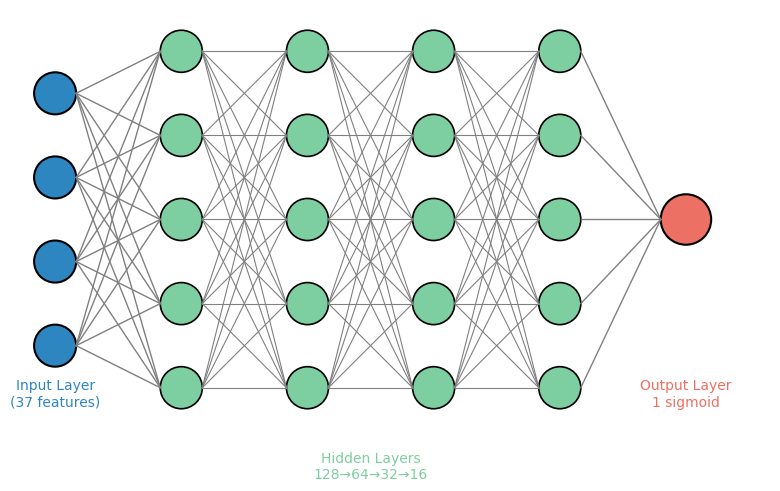

In [45]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# Improved diagram with true circles
fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('off')
ax.set_aspect('equal')

# Positions for sample nodes (not full count for clarity)
# We'll show 5 sample inputs instead of 37, and 5 per hidden layer to illustrate
input_ys = [0.8, 0.6, 0.4, 0.2]  # sample positions
hidden_xs = [0.4, 0.7, 1.0, 1.3]
hidden_ys = [0.9, 0.7, 0.5, 0.3, 0.1]
output_x, output_y = 1.6, 0.5

# Draw input nodes
for y in input_ys:
    node = Circle((0.1, y), 0.05, facecolor='#2E86C1', edgecolor='black', linewidth=1.5)
    ax.add_patch(node)

# Draw hidden nodes
for x in hidden_xs:
    for y in hidden_ys:
        node = Circle((x, y), 0.05, facecolor='#7DCEA0', edgecolor='black', linewidth=1.2)
        ax.add_patch(node)

# Draw output node
node = Circle((output_x, output_y), 0.06, facecolor='#EC7063', edgecolor='black', linewidth=1.5)
ax.add_patch(node)

# Draw full connections
# Input to first hidden layer
for y_i in input_ys:
    for y_h in hidden_ys:
        ax.add_line(Line2D([0.15, hidden_xs[0]-0.05], [y_i, y_h], color='gray', linewidth=1))

# Hidden to hidden
for i in range(len(hidden_xs) - 1):
    x0, x1 = hidden_xs[i] + 0.05, hidden_xs[i+1] - 0.05
    for y0 in hidden_ys:
        for y1 in hidden_ys:
            ax.add_line(Line2D([x0, x1], [y0, y1], color='gray', linewidth=0.8))

# Last hidden to output
for y_h in hidden_ys:
    ax.add_line(Line2D([hidden_xs[-1]+0.05, output_x-0.06], [y_h, output_y], color='gray', linewidth=1))

# Layer labels
ax.text(0.1, 0.05, "Input Layer\n(37 features)", ha='center', va='bottom', color='#2E86C1', fontsize=10)
ax.text(sum(hidden_xs)/4, -0.05, "Hidden Layers\n128→64→32→16", ha='center', va='top', color='#7DCEA0', fontsize=10)
ax.text(output_x, 0.05, "Output Layer\n1 sigmoid", ha='center', va='bottom', color='#EC7063', fontsize=10)

plt.xlim(0, 1.8)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
